## Instructions:
- You can use NN libraries such as tensorflow, pytorch, etc. But implement NF and importance sampling on your own.
- Zero tolerance for plagiarism. Do not copy from Practice and Share; the student who submitted there originally only can use; Github tracks who pushed what code.
- Total marks: 50 + 5 (bonus)
- Marks will be for plots and explanations. Describe your experiments, observations, challenges-faced, hyper-parameter tuning, etc., in the explanations.

In [1]:
import CodingQuiz1lib as given
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm

# Q1: Model a 2D GMM using NF
- Prepare the target probability distribution $p_x^*$ as a GMM with 5 components
```
    ptarget = given.GMM()  
    samples = ptarget.sample(5) # to obtain 5 samples
    given.plot_samples_2d(samples, filename='target')   # plot the samples in file
    ptarget.prob(samples)       # to obtain probability values of samples
```
- Prepare the source distribution $p_u$ as a Gaussian with zero mean and unit variance. Use `given.Gaussian`.

## a.
- Given only the samples from the target distribution, train an NF $x=T(u)$ to model that distribution. Use any flow of your choice.
- Evaluation:
    - Generate samples from the model and plot them using `given.plot_samples_2d()`. Also plot samples from target distribution for comparison. Write your obervations in the markdown block below the plots. [10 marks]
    - Generate samples from the given target distribution and estimate their probabilities using the model as well as `ptarget.prob()`. Plot a histogram of the absolute difference in the two probability values. Write your obervations in the markdown block below the plots. [10 marks]

## b.
- Given only the function `ptarget.prob()` from the target distribution, train an NF to model that distribution.
- Evaluation:
    - Generate samples from the model and plot them using `given.plot_samples_2d()`. Also plot samples from target distribution for comparison. Write your obervations in the markdown block below the plots. [10 marks]
    - Generate samples from the given target distribution and estimate their probabilities using the model as well as `ptarget.prob()`. Plot a histogram of the absolute difference in the two probability values. Write your obervations in the markdown block below the plots. [10 marks]

## c. (BONUS)
- Draw plots that may help understand your models better. Write your obervations in the markdown block below the plots. [5 marks]

## YOUR CODE:

### Q1 a.

In [2]:
##### Q1 a. #####

epoch = 500
ptarget = given.GMM()
psource = given.Gaussian(mu=np.asarray([0, 0]), sigma=np.asarray([[1, 0], [0, 1]]))
n_samples = 30
eta = 0.001

In [3]:
# modelling planar flow function

def T(u, c, w, b):
  return u + tf.matmul(tf.math.tanh(tf.matmul(u, w) + b), tf.transpose(c))

In [4]:
# function to find determinant of jacobian

def det_J(u, c, w, b):

  detJ = []

  for i in u:
    with tf.GradientTape(persistent=True) as tape:
      m = tf.matmul(tf.transpose(w), tf.reshape(i, (2,1))) + b
      h = tf.math.tanh(m)
    dh_dm = tape.gradient(h, m)
    det = 1 + (dh_dm)*tf.matmul(tf.transpose(w), c)
    detJ.append(det)

  return detJ

In [5]:
# initializing parameters

c = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32)
w = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32)
b = tf.Variable(tf.random.uniform([1, 1], 0, 1), trainable=True, dtype=tf.float32)

In [6]:
# S = 30
# D = 2

def step1(c, w, b, ptarget, psource, eta, n_samples, loss=False):
  with tf.GradientTape(persistent=True) as tape2:

    x = tf.cast(ptarget.sample(n_samples), dtype=tf.float32)
    u = T(x, c, w, b)
    # u = tf.cast(psource.sample(n_samples), dtype=tf.float32) # u = 30 x 2
    p_u_u = psource.prob(np.asarray(u)) # p_u_u = 30 x 1
    log_puu = tf.cast(tf.math.log(p_u_u), dtype=tf.float32) # log_puu = 30 x 1

    # x = T(u, c, w, b) # x = 30 x 2
    # p_x_star = ptarget.prob(np.asarray(x))   
    # log_pxstar = tf.cast(tf.math.log(p_x_star), dtype=tf.float32)

    mod_det_J = tf.math.abs(det_J(x, c, w, b))
    log_det_J = tf.math.log(mod_det_J)

    mc_loss = -tf.reduce_sum(log_puu + log_det_J)/n_samples
    
  dloss_dc = tape2.gradient(mc_loss, c)
  dloss_dw = tape2.gradient(mc_loss, w)
  dloss_db = tape2.gradient(mc_loss, b)
  c.assign(c - eta*dloss_dc)
  w.assign(w - eta*dloss_dw)
  b.assign(b - eta*dloss_db)

  if loss:
    return c, w, b, mc_loss.numpy()
  else:
    return c, w, b

In [7]:
for _ in tqdm.trange(epoch, desc="Training", bar_format='{l_bar}{bar:50}{r_bar}'):
  c, w, b = step1(c, w, b, ptarget, psource, eta, n_samples)

Training:   0%|                                                  | 0/500 [00:00<?, ?it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  0 14 15  1]


Training:   0%|                                                  | 1/500 [00:00<03:48,  2.18it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  3  8 17  0]


Training:   0%|▏                                                 | 2/500 [00:00<02:45,  3.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3  7 20  0]


Training:   1%|▎                                                 | 3/500 [00:00<02:27,  3.37it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  9 16  0]


Training:   1%|▍                                                 | 4/500 [00:01<02:19,  3.57it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 12 13  1]


Training:   1%|▌                                                 | 5/500 [00:01<02:15,  3.64it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6  8 16  0]


Training:   1%|▌                                                 | 6/500 [00:01<02:08,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  2 15 11  0]


Training:   1%|▋                                                 | 7/500 [00:01<02:05,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 17 11  0]


Training:   2%|▊                                                 | 8/500 [00:02<02:02,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 14 15  0]


Training:   2%|▉                                                 | 9/500 [00:02<02:03,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 14  0]


Training:   2%|█                                                 | 10/500 [00:02<02:04,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 10 15  2]


Training:   2%|█                                                 | 11/500 [00:02<02:01,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 3  3  9 15  0]


Training:   2%|█▏                                                | 12/500 [00:03<01:59,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 14 10  0]


Training:   3%|█▎                                                | 13/500 [00:03<02:00,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 14  1]


Training:   3%|█▍                                                | 14/500 [00:03<01:58,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  6 10 13  0]


Training:   3%|█▌                                                | 15/500 [00:03<01:57,  4.13it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 12  0]


Training:   3%|█▌                                                | 16/500 [00:04<01:59,  4.06it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 10 16  1]


Training:   3%|█▋                                                | 17/500 [00:04<01:57,  4.13it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 14 14  0]


Training:   4%|█▊                                                | 18/500 [00:04<01:54,  4.20it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 12 14  0]


Training:   4%|█▉                                                | 19/500 [00:04<01:57,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 17 10  0]


Training:   4%|██                                                | 20/500 [00:05<01:59,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 14 10  0]


Training:   4%|██                                                | 21/500 [00:05<01:59,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 15  0]


Training:   4%|██▏                                               | 22/500 [00:05<02:00,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 14  0]


Training:   5%|██▎                                               | 23/500 [00:05<01:59,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 11 17  0]


Training:   5%|██▍                                               | 24/500 [00:06<01:57,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 15 12  0]


Training:   5%|██▌                                               | 25/500 [00:06<01:55,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 11 17  0]


Training:   5%|██▌                                               | 26/500 [00:06<01:54,  4.13it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 11 12  0]


Training:   5%|██▋                                               | 27/500 [00:06<01:54,  4.14it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 14 14  0]


Training:   6%|██▊                                               | 28/500 [00:07<01:56,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 16  0]


Training:   6%|██▉                                               | 29/500 [00:07<01:57,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 15  9  0]


Training:   6%|███                                               | 30/500 [00:07<01:58,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 14  0]


Training:   6%|███                                               | 31/500 [00:07<01:57,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 10 14  0]


Training:   6%|███▏                                              | 32/500 [00:08<01:59,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 14  0]


Training:   7%|███▎                                              | 33/500 [00:08<01:59,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 11 16  0]


Training:   7%|███▍                                              | 34/500 [00:08<01:58,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 15 12  0]


Training:   7%|███▌                                              | 35/500 [00:08<01:58,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 14  0]


Training:   7%|███▌                                              | 36/500 [00:09<02:01,  3.83it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 15  0]


Training:   7%|███▋                                              | 37/500 [00:09<02:00,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1  9 19  1]


Training:   8%|███▊                                              | 38/500 [00:09<02:00,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 16  0]


Training:   8%|███▉                                              | 39/500 [00:09<01:59,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 12 13  0]


Training:   8%|████                                              | 40/500 [00:10<02:00,  3.82it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  6  7 14  2]


Training:   8%|████                                              | 41/500 [00:10<01:59,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:   8%|████▏                                             | 42/500 [00:10<01:58,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 10 15  0]


Training:   9%|████▎                                             | 43/500 [00:10<01:56,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 13 11  0]


Training:   9%|████▍                                             | 44/500 [00:11<01:55,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1 12 15  1]


Training:   9%|████▌                                             | 45/500 [00:11<01:53,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  2 11 15  0]


Training:   9%|████▌                                             | 46/500 [00:11<01:50,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 12  0]


Training:   9%|████▋                                             | 47/500 [00:11<01:50,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 12  1]


Training:  10%|████▊                                             | 48/500 [00:12<01:51,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 16  0]


Training:  10%|████▉                                             | 49/500 [00:12<01:49,  4.13it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 13 11  0]


Training:  10%|█████                                             | 50/500 [00:12<01:50,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  3 13 11  1]


Training:  10%|█████                                             | 51/500 [00:12<01:51,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 13 10  1]


Training:  10%|█████▏                                            | 52/500 [00:13<01:51,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  6 10 13  0]


Training:  11%|█████▎                                            | 53/500 [00:13<01:50,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 16 10  1]


Training:  11%|█████▍                                            | 54/500 [00:13<01:49,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 14 12  2]


Training:  11%|█████▌                                            | 55/500 [00:13<01:49,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  4 12 11  1]


Training:  11%|█████▌                                            | 56/500 [00:14<01:47,  4.13it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 14 11  0]


Training:  11%|█████▋                                            | 57/500 [00:14<01:48,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 15  0]


Training:  12%|█████▊                                            | 58/500 [00:14<01:46,  4.15it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 16  9  0]


Training:  12%|█████▉                                            | 59/500 [00:14<01:47,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2 10  9  9  0]


Training:  12%|██████                                            | 60/500 [00:15<01:46,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 20  9  0]


Training:  12%|██████                                            | 61/500 [00:15<01:48,  4.06it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2  8 20  0]


Training:  12%|██████▏                                           | 62/500 [00:15<01:48,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4  8 17  0]


Training:  13%|██████▎                                           | 63/500 [00:15<01:48,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 12 14  1]


Training:  13%|██████▍                                           | 64/500 [00:16<01:46,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 13 13  0]


Training:  13%|██████▌                                           | 65/500 [00:16<01:45,  4.11it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 17 10  0]


Training:  13%|██████▌                                           | 66/500 [00:16<01:45,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 11 16  0]


Training:  13%|██████▋                                           | 67/500 [00:16<01:45,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 14 11  0]


Training:  14%|██████▊                                           | 68/500 [00:17<01:46,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 12 16  1]


Training:  14%|██████▉                                           | 69/500 [00:17<01:47,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 10 15  0]


Training:  14%|███████                                           | 70/500 [00:17<01:48,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  0 16 13  1]


Training:  14%|███████                                           | 71/500 [00:17<01:47,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 13  1]


Training:  14%|███████▏                                          | 72/500 [00:18<01:45,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1 14 14  0]


Training:  15%|███████▎                                          | 73/500 [00:18<01:44,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 12 11  0]


Training:  15%|███████▍                                          | 74/500 [00:18<01:45,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 11 12  0]


Training:  15%|███████▌                                          | 75/500 [00:18<01:46,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 16 10  1]


Training:  15%|███████▌                                          | 76/500 [00:19<01:46,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 17 12  0]


Training:  15%|███████▋                                          | 77/500 [00:19<01:46,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  9 17  0]


Training:  16%|███████▊                                          | 78/500 [00:19<01:46,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 14 14  0]


Training:  16%|███████▉                                          | 79/500 [00:19<01:47,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 11 14  1]


Training:  16%|████████                                          | 80/500 [00:20<01:46,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1 12 16  0]


Training:  16%|████████                                          | 81/500 [00:20<01:48,  3.87it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3  9 15  2]


Training:  16%|████████▏                                         | 82/500 [00:20<01:48,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  4 13 11  0]


Training:  17%|████████▎                                         | 83/500 [00:20<01:47,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 13 12  0]


Training:  17%|████████▍                                         | 84/500 [00:21<01:46,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4  8 17  0]


Training:  17%|████████▌                                         | 85/500 [00:21<01:48,  3.82it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 13  2]


Training:  17%|████████▌                                         | 86/500 [00:21<01:49,  3.80it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 14 10  1]


Training:  17%|████████▋                                         | 87/500 [00:21<01:48,  3.79it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3  9 18  0]


Training:  18%|████████▊                                         | 88/500 [00:22<01:47,  3.82it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 14  1]


Training:  18%|████████▉                                         | 89/500 [00:22<01:48,  3.79it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 15 10  0]


Training:  18%|█████████                                         | 90/500 [00:22<01:48,  3.78it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  7 10 11  1]


Training:  18%|█████████                                         | 91/500 [00:23<01:46,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 12 12  0]


Training:  18%|█████████▏                                        | 92/500 [00:23<01:45,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  9  9 11  1]


Training:  19%|█████████▎                                        | 93/500 [00:23<01:47,  3.77it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  8 10  9  3]


Training:  19%|█████████▍                                        | 94/500 [00:23<01:45,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 12 10  1]


Training:  19%|█████████▌                                        | 95/500 [00:24<01:44,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 19  8  0]


Training:  19%|█████████▌                                        | 96/500 [00:24<01:41,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  9 16  0]


Training:  19%|█████████▋                                        | 97/500 [00:24<01:40,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 16  8  0]


Training:  20%|█████████▊                                        | 98/500 [00:24<01:39,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 12 14  1]


Training:  20%|█████████▉                                        | 99/500 [00:25<01:38,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 10 16  1]


Training:  20%|██████████                                        | 100/500 [00:25<01:39,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 10 15  2]


Training:  20%|██████████                                        | 101/500 [00:25<01:41,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  8 18  0]


Training:  20%|██████████▏                                       | 102/500 [00:25<01:41,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 12 16  0]


Training:  21%|██████████▎                                       | 103/500 [00:26<01:40,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 11  2]


Training:  21%|██████████▍                                       | 104/500 [00:26<01:40,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3  8 17  1]


Training:  21%|██████████▌                                       | 105/500 [00:26<01:42,  3.87it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7  9 14  0]


Training:  21%|██████████▌                                       | 106/500 [00:26<01:40,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 15 12  0]


Training:  21%|██████████▋                                       | 107/500 [00:27<01:38,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 14 12  1]


Training:  22%|██████████▊                                       | 108/500 [00:27<01:36,  4.06it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 13 12  0]


Training:  22%|██████████▉                                       | 109/500 [00:27<01:36,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 11  1]


Training:  22%|███████████                                       | 110/500 [00:27<01:38,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  22%|███████████                                       | 111/500 [00:28<01:38,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 15 11  2]


Training:  22%|███████████▏                                      | 112/500 [00:28<01:37,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 14  2]


Training:  23%|███████████▎                                      | 113/500 [00:28<01:38,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1 13 14  1]


Training:  23%|███████████▍                                      | 114/500 [00:28<01:40,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 10 16  0]


Training:  23%|███████████▌                                      | 115/500 [00:29<01:38,  3.90it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 13  0]


Training:  23%|███████████▌                                      | 116/500 [00:29<01:36,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  23%|███████████▋                                      | 117/500 [00:29<01:35,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  8 10 12  0]


Training:  24%|███████████▊                                      | 118/500 [00:29<01:34,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  7 12  9  1]


Training:  24%|███████████▉                                      | 119/500 [00:30<01:35,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 16 11  1]


Training:  24%|████████████                                      | 120/500 [00:30<01:35,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  6 10 12  1]


Training:  24%|████████████                                      | 121/500 [00:30<01:34,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 14 10  1]


Training:  24%|████████████▏                                     | 122/500 [00:30<01:33,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 14 12  0]


Training:  25%|████████████▎                                     | 123/500 [00:31<01:34,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 14  0]


Training:  25%|████████████▍                                     | 124/500 [00:31<01:32,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 13 10  0]


Training:  25%|████████████▌                                     | 125/500 [00:31<01:31,  4.11it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 11  1]


Training:  25%|████████████▌                                     | 126/500 [00:31<01:30,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 15  9  0]


Training:  25%|████████████▋                                     | 127/500 [00:32<01:32,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 12  2]


Training:  26%|████████████▊                                     | 128/500 [00:32<01:29,  4.14it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 14  0]


Training:  26%|████████████▉                                     | 129/500 [00:32<01:28,  4.17it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  0 15 14  0]


Training:  26%|█████████████                                     | 130/500 [00:32<01:29,  4.14it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  8 17  1]


Training:  26%|█████████████                                     | 131/500 [00:33<01:30,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 10 17  0]


Training:  26%|█████████████▏                                    | 132/500 [00:33<01:31,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 14  9  1]


Training:  27%|█████████████▎                                    | 133/500 [00:33<01:31,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  9 17  0]


Training:  27%|█████████████▍                                    | 134/500 [00:33<01:32,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  9 14  3]


Training:  27%|█████████████▌                                    | 135/500 [00:34<01:31,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 15 11  0]


Training:  27%|█████████████▌                                    | 136/500 [00:34<01:29,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 12 12  0]


Training:  27%|█████████████▋                                    | 137/500 [00:34<01:28,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  8 11 10  1]


Training:  28%|█████████████▊                                    | 138/500 [00:34<01:28,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 15  0]


Training:  28%|█████████████▉                                    | 139/500 [00:34<01:28,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 10 14  0]


Training:  28%|██████████████                                    | 140/500 [00:35<01:29,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 17 11  0]


Training:  28%|██████████████                                    | 141/500 [00:35<01:29,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 11 13  0]


Training:  28%|██████████████▏                                   | 142/500 [00:35<01:31,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 16  0]


Training:  29%|██████████████▎                                   | 143/500 [00:36<01:31,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  2 12 13  1]


Training:  29%|██████████████▍                                   | 144/500 [00:36<01:30,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 13 13  0]


Training:  29%|██████████████▍                                   | 145/500 [00:36<01:30,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 10 18  1]


Training:  29%|██████████████▌                                   | 146/500 [00:36<01:32,  3.82it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 17  8  1]


Training:  29%|██████████████▋                                   | 147/500 [00:37<01:31,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  3 12 12  1]


Training:  30%|██████████████▊                                   | 148/500 [00:37<01:30,  3.87it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 11 13  0]


Training:  30%|██████████████▉                                   | 149/500 [00:37<01:28,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2  9 18  1]


Training:  30%|███████████████                                   | 150/500 [00:37<01:27,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 15 10  0]


Training:  30%|███████████████                                   | 151/500 [00:38<01:26,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 11 17  0]


Training:  30%|███████████████▏                                  | 152/500 [00:38<01:24,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  6 10 11  1]


Training:  31%|███████████████▎                                  | 153/500 [00:38<01:24,  4.13it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  4 14 10  0]


Training:  31%|███████████████▍                                  | 154/500 [00:38<01:24,  4.11it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 11  2]


Training:  31%|███████████████▌                                  | 155/500 [00:39<01:24,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  1 11 15  1]


Training:  31%|███████████████▌                                  | 156/500 [00:39<01:23,  4.14it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 14 10  0]


Training:  31%|███████████████▋                                  | 157/500 [00:39<01:22,  4.17it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  6 11 11  0]


Training:  32%|███████████████▊                                  | 158/500 [00:39<01:22,  4.15it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 15 12  0]


Training:  32%|███████████████▉                                  | 159/500 [00:39<01:22,  4.14it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 14 13  0]


Training:  32%|████████████████                                  | 160/500 [00:40<01:21,  4.16it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7  9 14  0]


Training:  32%|████████████████                                  | 161/500 [00:40<01:20,  4.24it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  7 13  9  0]


Training:  32%|████████████████▏                                 | 162/500 [00:40<01:19,  4.23it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  2 13 12  1]


Training:  33%|████████████████▎                                 | 163/500 [00:40<01:23,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 17  9  0]


Training:  33%|████████████████▍                                 | 164/500 [00:41<01:24,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 14  1]


Training:  33%|████████████████▌                                 | 165/500 [00:41<01:23,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 16 10  0]


Training:  33%|████████████████▌                                 | 166/500 [00:41<01:25,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  33%|████████████████▋                                 | 167/500 [00:41<01:24,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  9 16  1]


Training:  34%|████████████████▊                                 | 168/500 [00:42<01:23,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 12 12  1]


Training:  34%|████████████████▉                                 | 169/500 [00:42<01:23,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 11  2]


Training:  34%|█████████████████                                 | 170/500 [00:42<01:23,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 11 13  0]


Training:  34%|█████████████████                                 | 171/500 [00:42<01:23,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 15 13  0]


Training:  34%|█████████████████▏                                | 172/500 [00:43<01:21,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  35%|█████████████████▎                                | 173/500 [00:43<01:19,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 13 11  0]


Training:  35%|█████████████████▍                                | 174/500 [00:43<01:20,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 14  0]


Training:  35%|█████████████████▌                                | 175/500 [00:43<01:22,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 11  1]


Training:  35%|█████████████████▌                                | 176/500 [00:44<01:21,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 12 11  1]


Training:  35%|█████████████████▋                                | 177/500 [00:44<01:22,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  4 11 13  0]


Training:  36%|█████████████████▊                                | 178/500 [00:44<01:21,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 14  0]


Training:  36%|█████████████████▉                                | 179/500 [00:44<01:21,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 11 17  0]


Training:  36%|██████████████████                                | 180/500 [00:45<01:20,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  36%|██████████████████                                | 181/500 [00:45<01:18,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 11 14  0]


Training:  36%|██████████████████▏                               | 182/500 [00:45<01:17,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7  8 15  0]


Training:  37%|██████████████████▎                               | 183/500 [00:45<01:18,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 18 11  0]


Training:  37%|██████████████████▍                               | 184/500 [00:46<01:20,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 14 14  0]


Training:  37%|██████████████████▌                               | 185/500 [00:46<01:19,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 13  1]


Training:  37%|██████████████████▌                               | 186/500 [00:46<01:19,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 15 10  0]


Training:  37%|██████████████████▋                               | 187/500 [00:46<01:18,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 13 10  2]


Training:  38%|██████████████████▊                               | 188/500 [00:47<01:17,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5  5 18  1]


Training:  38%|██████████████████▉                               | 189/500 [00:47<01:18,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 15  8  0]


Training:  38%|███████████████████                               | 190/500 [00:47<01:18,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 15 12  1]


Training:  38%|███████████████████                               | 191/500 [00:47<01:17,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 15 10  0]


Training:  38%|███████████████████▏                              | 192/500 [00:48<01:16,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 12  0]


Training:  39%|███████████████████▎                              | 193/500 [00:48<01:15,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 10 15  0]


Training:  39%|███████████████████▍                              | 194/500 [00:48<01:16,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  39%|███████████████████▌                              | 195/500 [00:48<01:14,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 14 12  1]


Training:  39%|███████████████████▌                              | 196/500 [00:49<01:14,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 15  1]


Training:  39%|███████████████████▋                              | 197/500 [00:49<01:15,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 10 13  1]


Training:  40%|███████████████████▊                              | 198/500 [00:49<01:14,  4.06it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  9 16  1]


Training:  40%|███████████████████▉                              | 199/500 [00:49<01:14,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 15  1]


Training:  40%|████████████████████                              | 200/500 [00:50<01:14,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  2 15 11  0]


Training:  40%|████████████████████                              | 201/500 [00:50<01:13,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 20  7  0]


Training:  40%|████████████████████▏                             | 202/500 [00:50<01:11,  4.15it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 16 11  0]


Training:  41%|████████████████████▎                             | 203/500 [00:50<01:11,  4.15it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  9 17  0]


Training:  41%|████████████████████▍                             | 204/500 [00:51<01:12,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  8  4 18  0]


Training:  41%|████████████████████▌                             | 205/500 [00:51<01:13,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 13  0]


Training:  41%|████████████████████▌                             | 206/500 [00:51<01:12,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3  9 18  0]


Training:  41%|████████████████████▋                             | 207/500 [00:51<01:11,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 13 16  0]


Training:  42%|████████████████████▊                             | 208/500 [00:52<01:12,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 14 11  0]


Training:  42%|████████████████████▉                             | 209/500 [00:52<01:12,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 10 13  0]


Training:  42%|█████████████████████                             | 210/500 [00:52<01:11,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 15 11  0]


Training:  42%|█████████████████████                             | 211/500 [00:52<01:11,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 15  9  0]


Training:  42%|█████████████████████▏                            | 212/500 [00:53<01:11,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 16 12  0]


Training:  43%|█████████████████████▎                            | 213/500 [00:53<01:11,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 12 17  0]


Training:  43%|█████████████████████▍                            | 214/500 [00:53<01:10,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 11 15  0]


Training:  43%|█████████████████████▌                            | 215/500 [00:53<01:10,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 15  0]


Training:  43%|█████████████████████▌                            | 216/500 [00:54<01:12,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 15 10  0]


Training:  43%|█████████████████████▋                            | 217/500 [00:54<01:12,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 13  1]


Training:  44%|█████████████████████▊                            | 218/500 [00:54<01:12,  3.90it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 13  1]


Training:  44%|█████████████████████▉                            | 219/500 [00:54<01:11,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 14 12  0]


Training:  44%|██████████████████████                            | 220/500 [00:55<01:11,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  9 16  0]


Training:  44%|██████████████████████                            | 221/500 [00:55<01:10,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 10 14  1]


Training:  44%|██████████████████████▏                           | 222/500 [00:55<01:11,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 15 10  1]


Training:  45%|██████████████████████▎                           | 223/500 [00:55<01:10,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 15  9  1]


Training:  45%|██████████████████████▍                           | 224/500 [00:56<01:11,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 15 13  0]


Training:  45%|██████████████████████▌                           | 225/500 [00:56<01:12,  3.81it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  8 18  0]


Training:  45%|██████████████████████▌                           | 226/500 [00:56<01:11,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2  9 19  0]


Training:  45%|██████████████████████▋                           | 227/500 [00:57<01:10,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 13 10  1]


Training:  46%|██████████████████████▊                           | 228/500 [00:57<01:10,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 12 16  0]


Training:  46%|██████████████████████▉                           | 229/500 [00:57<01:08,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 14 12  0]


Training:  46%|███████████████████████                           | 230/500 [00:57<01:07,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 10 15  0]


Training:  46%|███████████████████████                           | 231/500 [00:58<01:07,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5  8 16  0]


Training:  46%|███████████████████████▏                          | 232/500 [00:58<01:08,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  8 11 11  0]


Training:  47%|███████████████████████▎                          | 233/500 [00:58<01:08,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2  7 19  2]


Training:  47%|███████████████████████▍                          | 234/500 [00:58<01:08,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 15  9  1]


Training:  47%|███████████████████████▌                          | 235/500 [00:59<01:08,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  2 14 12  0]


Training:  47%|███████████████████████▌                          | 236/500 [00:59<01:09,  3.82it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 14 11  0]


Training:  47%|███████████████████████▋                          | 237/500 [00:59<01:09,  3.79it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 3  4 12 11  0]


Training:  48%|███████████████████████▊                          | 238/500 [00:59<01:08,  3.82it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  5 13 10  0]


Training:  48%|███████████████████████▉                          | 239/500 [01:00<01:06,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 14  0]


Training:  48%|████████████████████████                          | 240/500 [01:00<01:07,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  8 15  2]


Training:  48%|████████████████████████                          | 241/500 [01:00<01:06,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  5 12 10  1]


Training:  48%|████████████████████████▏                         | 242/500 [01:00<01:04,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 13  1]


Training:  49%|████████████████████████▎                         | 243/500 [01:01<01:06,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2  9 16  2]


Training:  49%|████████████████████████▍                         | 244/500 [01:01<01:08,  3.74it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 10 15  1]


Training:  49%|████████████████████████▌                         | 245/500 [01:01<01:08,  3.72it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 12 16  1]


Training:  49%|████████████████████████▌                         | 246/500 [01:01<01:06,  3.79it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 13  9  1]


Training:  49%|████████████████████████▋                         | 247/500 [01:02<01:05,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 14 10  0]


Training:  50%|████████████████████████▊                         | 248/500 [01:02<01:06,  3.78it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 12 10  1]


Training:  50%|████████████████████████▉                         | 249/500 [01:02<01:06,  3.78it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 11 13  0]


Training:  50%|█████████████████████████                         | 250/500 [01:02<01:05,  3.79it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  50%|█████████████████████████                         | 251/500 [01:03<01:04,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  50%|█████████████████████████▏                        | 252/500 [01:03<01:03,  3.90it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 15  0]


Training:  51%|█████████████████████████▎                        | 253/500 [01:03<01:01,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  6 10 11  2]


Training:  51%|█████████████████████████▍                        | 254/500 [01:03<01:01,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3  6 21  0]


Training:  51%|█████████████████████████▌                        | 255/500 [01:04<01:01,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 11 14  0]


Training:  51%|█████████████████████████▌                        | 256/500 [01:04<01:01,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  9 15  1]


Training:  51%|█████████████████████████▋                        | 257/500 [01:04<01:01,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  6 10 13  0]


Training:  52%|█████████████████████████▊                        | 258/500 [01:04<01:01,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 10 18  0]


Training:  52%|█████████████████████████▉                        | 259/500 [01:05<01:01,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 12  2]


Training:  52%|██████████████████████████                        | 260/500 [01:05<01:00,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 16  9  1]


Training:  52%|██████████████████████████                        | 261/500 [01:05<00:59,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  7  9 12  1]


Training:  52%|██████████████████████████▏                       | 262/500 [01:05<00:58,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 14  0]


Training:  53%|██████████████████████████▎                       | 263/500 [01:06<00:59,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1 13 15  0]


Training:  53%|██████████████████████████▍                       | 264/500 [01:06<00:59,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  9 16  0]


Training:  53%|██████████████████████████▌                       | 265/500 [01:06<00:59,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 12 15  0]


Training:  53%|██████████████████████████▌                       | 266/500 [01:06<00:59,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  9 16  1]


Training:  53%|██████████████████████████▋                       | 267/500 [01:07<00:59,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3  9 17  1]


Training:  54%|██████████████████████████▊                       | 268/500 [01:07<00:58,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 10 15  0]


Training:  54%|██████████████████████████▉                       | 269/500 [01:07<00:57,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  8 17  0]


Training:  54%|███████████████████████████                       | 270/500 [01:07<00:57,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 12 15  1]


Training:  54%|███████████████████████████                       | 271/500 [01:08<00:58,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 10 15  0]


Training:  54%|███████████████████████████▏                      | 272/500 [01:08<00:56,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 16 12  0]


Training:  55%|███████████████████████████▎                      | 273/500 [01:08<00:56,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  0 15 14  0]


Training:  55%|███████████████████████████▍                      | 274/500 [01:08<00:56,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 14  1]


Training:  55%|███████████████████████████▌                      | 275/500 [01:09<00:55,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 10 13  1]


Training:  55%|███████████████████████████▌                      | 276/500 [01:09<00:55,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2  8 18  2]


Training:  55%|███████████████████████████▋                      | 277/500 [01:09<00:55,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 17  8  1]


Training:  56%|███████████████████████████▊                      | 278/500 [01:09<00:55,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 15 13  1]


Training:  56%|███████████████████████████▉                      | 279/500 [01:10<00:55,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 14  0]


Training:  56%|████████████████████████████                      | 280/500 [01:10<00:55,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  4 13 11  0]


Training:  56%|████████████████████████████                      | 281/500 [01:10<00:55,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 10 14  1]


Training:  56%|████████████████████████████▏                     | 282/500 [01:10<00:54,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  6  7 15  0]


Training:  57%|████████████████████████████▎                     | 283/500 [01:11<00:53,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 14  0]


Training:  57%|████████████████████████████▍                     | 284/500 [01:11<00:52,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 13 11  1]


Training:  57%|████████████████████████████▍                     | 285/500 [01:11<00:53,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 10 16  0]


Training:  57%|████████████████████████████▌                     | 286/500 [01:11<00:54,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 14  0]


Training:  57%|████████████████████████████▋                     | 287/500 [01:12<00:53,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 15  0]


Training:  58%|████████████████████████████▊                     | 288/500 [01:12<00:55,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 10 16  1]


Training:  58%|████████████████████████████▉                     | 289/500 [01:12<00:55,  3.81it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 12 13  0]


Training:  58%|████████████████████████████▉                     | 290/500 [01:13<00:54,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  7  6 15  1]


Training:  58%|█████████████████████████████                     | 291/500 [01:13<00:54,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 14 11  0]


Training:  58%|█████████████████████████████▏                    | 292/500 [01:13<00:54,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 13 10  0]


Training:  59%|█████████████████████████████▎                    | 293/500 [01:13<00:53,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 16 11  1]


Training:  59%|█████████████████████████████▍                    | 294/500 [01:14<00:52,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 13 12  0]


Training:  59%|█████████████████████████████▌                    | 295/500 [01:14<00:51,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 12 12  0]


Training:  59%|█████████████████████████████▌                    | 296/500 [01:14<00:50,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 10 17  0]


Training:  59%|█████████████████████████████▋                    | 297/500 [01:14<00:51,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  60%|█████████████████████████████▊                    | 298/500 [01:15<00:50,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6  9 14  1]


Training:  60%|█████████████████████████████▉                    | 299/500 [01:15<00:50,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 13 12  0]


Training:  60%|██████████████████████████████                    | 300/500 [01:15<00:50,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  0 14 14  1]


Training:  60%|██████████████████████████████                    | 301/500 [01:15<00:51,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 10 16  0]


Training:  60%|██████████████████████████████▏                   | 302/500 [01:16<00:50,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  7 10 12  0]


Training:  61%|██████████████████████████████▎                   | 303/500 [01:16<00:50,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 13  0]


Training:  61%|██████████████████████████████▍                   | 304/500 [01:16<00:50,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 14  1]


Training:  61%|██████████████████████████████▌                   | 305/500 [01:16<00:50,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 10 17  0]


Training:  61%|██████████████████████████████▌                   | 306/500 [01:17<00:48,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 14 11  0]


Training:  61%|██████████████████████████████▋                   | 307/500 [01:17<00:48,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 10 15  1]


Training:  62%|██████████████████████████████▊                   | 308/500 [01:17<00:47,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 15 13  0]


Training:  62%|██████████████████████████████▉                   | 309/500 [01:17<00:48,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  9 17  0]


Training:  62%|███████████████████████████████                   | 310/500 [01:18<00:47,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  62%|███████████████████████████████                   | 311/500 [01:18<00:46,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  3 10 15  0]


Training:  62%|███████████████████████████████▏                  | 312/500 [01:18<00:46,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 14 12  0]


Training:  63%|███████████████████████████████▎                  | 313/500 [01:18<00:46,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 14 15  0]


Training:  63%|███████████████████████████████▍                  | 314/500 [01:19<00:46,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 14 15  0]


Training:  63%|███████████████████████████████▌                  | 315/500 [01:19<00:46,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 12  0]


Training:  63%|███████████████████████████████▌                  | 316/500 [01:19<00:46,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3  8 17  2]


Training:  63%|███████████████████████████████▋                  | 317/500 [01:19<00:46,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 13  1]


Training:  64%|███████████████████████████████▊                  | 318/500 [01:20<00:45,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  9 11 10  0]


Training:  64%|███████████████████████████████▉                  | 319/500 [01:20<00:46,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2  9 19  0]


Training:  64%|████████████████████████████████                  | 320/500 [01:20<00:45,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 12 13  0]


Training:  64%|████████████████████████████████                  | 321/500 [01:20<00:46,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  8 18  0]


Training:  64%|████████████████████████████████▏                 | 322/500 [01:21<00:44,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 13  0]


Training:  65%|████████████████████████████████▎                 | 323/500 [01:21<00:43,  4.06it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  8 17  0]


Training:  65%|████████████████████████████████▍                 | 324/500 [01:21<00:43,  4.06it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  7 18  0]


Training:  65%|████████████████████████████████▌                 | 325/500 [01:21<00:43,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  9 17  0]


Training:  65%|████████████████████████████████▌                 | 326/500 [01:22<00:43,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 15  1]


Training:  65%|████████████████████████████████▋                 | 327/500 [01:22<00:44,  3.90it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 15  0]


Training:  66%|████████████████████████████████▊                 | 328/500 [01:22<00:44,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5  8 16  0]


Training:  66%|████████████████████████████████▉                 | 329/500 [01:22<00:43,  3.90it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 14 12  2]


Training:  66%|█████████████████████████████████                 | 330/500 [01:23<00:43,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 15 10  0]


Training:  66%|█████████████████████████████████                 | 331/500 [01:23<00:42,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 16 10  0]


Training:  66%|█████████████████████████████████▏                | 332/500 [01:23<00:41,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 15  0]


Training:  67%|█████████████████████████████████▎                | 333/500 [01:23<00:40,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 12 15  1]


Training:  67%|█████████████████████████████████▍                | 334/500 [01:24<00:40,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 10 16  0]


Training:  67%|█████████████████████████████████▌                | 335/500 [01:24<00:40,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 14  0]


Training:  67%|█████████████████████████████████▌                | 336/500 [01:24<00:41,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  5  7 16  0]


Training:  67%|█████████████████████████████████▋                | 337/500 [01:24<00:41,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  3 13 11  1]


Training:  68%|█████████████████████████████████▊                | 338/500 [01:25<00:41,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  8 18  0]


Training:  68%|█████████████████████████████████▉                | 339/500 [01:25<00:41,  3.90it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 15  0]


Training:  68%|██████████████████████████████████                | 340/500 [01:25<00:41,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 11 12  0]


Training:  68%|██████████████████████████████████                | 341/500 [01:25<00:40,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 3  4 14  9  0]


Training:  68%|██████████████████████████████████▏               | 342/500 [01:26<00:40,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 10 15  0]


Training:  69%|██████████████████████████████████▎               | 343/500 [01:26<00:39,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  69%|██████████████████████████████████▍               | 344/500 [01:26<00:38,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  2 15 10  1]


Training:  69%|██████████████████████████████████▌               | 345/500 [01:26<00:38,  4.06it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 14 11  0]


Training:  69%|██████████████████████████████████▌               | 346/500 [01:27<00:38,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6  9 15  0]


Training:  69%|██████████████████████████████████▋               | 347/500 [01:27<00:37,  4.11it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  1  9 18  0]


Training:  70%|██████████████████████████████████▊               | 348/500 [01:27<00:37,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 12 15  1]


Training:  70%|██████████████████████████████████▉               | 349/500 [01:27<00:36,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 13  1]


Training:  70%|███████████████████████████████████               | 350/500 [01:28<00:36,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 17 10  0]


Training:  70%|███████████████████████████████████               | 351/500 [01:28<00:36,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4  8 16  1]


Training:  70%|███████████████████████████████████▏              | 352/500 [01:28<00:36,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 15  1]


Training:  71%|███████████████████████████████████▎              | 353/500 [01:28<00:35,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 13 12  0]


Training:  71%|███████████████████████████████████▍              | 354/500 [01:29<00:35,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 13 13  0]


Training:  71%|███████████████████████████████████▌              | 355/500 [01:29<00:36,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  71%|███████████████████████████████████▌              | 356/500 [01:29<00:35,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 13 10  2]


Training:  71%|███████████████████████████████████▋              | 357/500 [01:29<00:35,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 11  2]


Training:  72%|███████████████████████████████████▊              | 358/500 [01:30<00:34,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 14  0]


Training:  72%|███████████████████████████████████▉              | 359/500 [01:30<00:34,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 10 15  1]


Training:  72%|████████████████████████████████████              | 360/500 [01:30<00:34,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 11 16  0]


Training:  72%|████████████████████████████████████              | 361/500 [01:30<00:33,  4.16it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 17 11  0]


Training:  72%|████████████████████████████████████▏             | 362/500 [01:31<00:33,  4.11it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 14  0]


Training:  73%|████████████████████████████████████▎             | 363/500 [01:31<00:33,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  4 13 11  0]


Training:  73%|████████████████████████████████████▍             | 364/500 [01:31<00:33,  4.11it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 11 12  0]


Training:  73%|████████████████████████████████████▌             | 365/500 [01:31<00:33,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 10 15  1]


Training:  73%|████████████████████████████████████▌             | 366/500 [01:32<00:32,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 15 12  0]


Training:  73%|████████████████████████████████████▋             | 367/500 [01:32<00:32,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 10 13  0]


Training:  74%|████████████████████████████████████▊             | 368/500 [01:32<00:32,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 12 15  1]


Training:  74%|████████████████████████████████████▉             | 369/500 [01:32<00:31,  4.14it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1 13 15  0]


Training:  74%|█████████████████████████████████████             | 370/500 [01:33<00:31,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  1 11 16  0]


Training:  74%|█████████████████████████████████████             | 371/500 [01:33<00:32,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 10 15  0]


Training:  74%|█████████████████████████████████████▏            | 372/500 [01:33<00:32,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  8  8 11  3]


Training:  75%|█████████████████████████████████████▎            | 373/500 [01:33<00:32,  3.87it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 16  9  1]


Training:  75%|█████████████████████████████████████▍            | 374/500 [01:34<00:32,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 11 16  0]


Training:  75%|█████████████████████████████████████▌            | 375/500 [01:34<00:32,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  5 13 10  0]


Training:  75%|█████████████████████████████████████▌            | 376/500 [01:34<00:32,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 17  7  0]


Training:  75%|█████████████████████████████████████▋            | 377/500 [01:35<00:44,  2.74it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 14  1]


Training:  76%|█████████████████████████████████████▊            | 378/500 [01:35<00:41,  2.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 10 14  0]


Training:  76%|█████████████████████████████████████▉            | 379/500 [01:35<00:38,  3.16it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1  9 19  1]


Training:  76%|██████████████████████████████████████            | 380/500 [01:35<00:35,  3.37it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 15 13  0]


Training:  76%|██████████████████████████████████████            | 381/500 [01:36<00:34,  3.44it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7  9 14  0]


Training:  76%|██████████████████████████████████████▏           | 382/500 [01:36<00:33,  3.56it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 17 12  0]


Training:  77%|██████████████████████████████████████▎           | 383/500 [01:36<00:31,  3.67it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 11 13  0]


Training:  77%|██████████████████████████████████████▍           | 384/500 [01:37<00:31,  3.73it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 14 11  0]


Training:  77%|██████████████████████████████████████▌           | 385/500 [01:37<00:30,  3.76it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6  6 18  0]


Training:  77%|██████████████████████████████████████▌           | 386/500 [01:37<00:29,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6  9 15  0]


Training:  77%|██████████████████████████████████████▋           | 387/500 [01:37<00:28,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 16  0]


Training:  78%|██████████████████████████████████████▊           | 388/500 [01:38<00:27,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 14 14  0]


Training:  78%|██████████████████████████████████████▉           | 389/500 [01:38<00:27,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 12 11  0]


Training:  78%|███████████████████████████████████████           | 390/500 [01:38<00:27,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 12 14  1]


Training:  78%|███████████████████████████████████████           | 391/500 [01:38<00:26,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 14 11  1]


Training:  78%|███████████████████████████████████████▏          | 392/500 [01:38<00:26,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 16  9  2]


Training:  79%|███████████████████████████████████████▎          | 393/500 [01:39<00:26,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 12  1]


Training:  79%|███████████████████████████████████████▍          | 394/500 [01:39<00:26,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 12 17  0]


Training:  79%|███████████████████████████████████████▌          | 395/500 [01:39<00:26,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 10 15  0]


Training:  79%|███████████████████████████████████████▌          | 396/500 [01:39<00:25,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 18  9  1]


Training:  79%|███████████████████████████████████████▋          | 397/500 [01:40<00:25,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 10 14  1]


Training:  80%|███████████████████████████████████████▊          | 398/500 [01:40<00:25,  4.04it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 14 12  2]


Training:  80%|███████████████████████████████████████▉          | 399/500 [01:40<00:24,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  80%|████████████████████████████████████████          | 400/500 [01:40<00:24,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  80%|████████████████████████████████████████          | 401/500 [01:41<00:24,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1 10 16  2]


Training:  80%|████████████████████████████████████████▏         | 402/500 [01:41<00:25,  3.90it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5  7 16  1]


Training:  81%|████████████████████████████████████████▎         | 403/500 [01:41<00:25,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 10 15  1]


Training:  81%|████████████████████████████████████████▍         | 404/500 [01:42<00:25,  3.83it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 13  1]


Training:  81%|████████████████████████████████████████▌         | 405/500 [01:42<00:24,  3.82it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 10 16  2]


Training:  81%|████████████████████████████████████████▌         | 406/500 [01:42<00:24,  3.81it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 12  0]


Training:  81%|████████████████████████████████████████▋         | 407/500 [01:42<00:24,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  8 12 10  0]


Training:  82%|████████████████████████████████████████▊         | 408/500 [01:43<00:23,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1 13 15  0]


Training:  82%|████████████████████████████████████████▉         | 409/500 [01:43<00:22,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  6 19  1]


Training:  82%|█████████████████████████████████████████         | 410/500 [01:43<00:22,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 11 12  1]


Training:  82%|█████████████████████████████████████████         | 411/500 [01:43<00:22,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 10 15  0]


Training:  82%|█████████████████████████████████████████▏        | 412/500 [01:44<00:22,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 15 13  0]


Training:  83%|█████████████████████████████████████████▎        | 413/500 [01:44<00:22,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 14  0]


Training:  83%|█████████████████████████████████████████▍        | 414/500 [01:44<00:22,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 16  9  0]


Training:  83%|█████████████████████████████████████████▌        | 415/500 [01:44<00:21,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 11 15  1]


Training:  83%|█████████████████████████████████████████▌        | 416/500 [01:45<00:20,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 16  9  2]


Training:  83%|█████████████████████████████████████████▋        | 417/500 [01:45<00:20,  4.06it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  84%|█████████████████████████████████████████▊        | 418/500 [01:45<00:20,  3.94it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 14  0]


Training:  84%|█████████████████████████████████████████▉        | 419/500 [01:45<00:20,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 15 13  0]


Training:  84%|██████████████████████████████████████████        | 420/500 [01:46<00:20,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  84%|██████████████████████████████████████████        | 421/500 [01:46<00:19,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  84%|██████████████████████████████████████████▏       | 422/500 [01:46<00:20,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 15  0]


Training:  85%|██████████████████████████████████████████▎       | 423/500 [01:46<00:19,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 15 14  0]


Training:  85%|██████████████████████████████████████████▍       | 424/500 [01:47<00:19,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 13 13  0]


Training:  85%|██████████████████████████████████████████▌       | 425/500 [01:47<00:18,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  7 10 13  0]


Training:  85%|██████████████████████████████████████████▌       | 426/500 [01:47<00:18,  3.93it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 13  0]


Training:  85%|██████████████████████████████████████████▋       | 427/500 [01:47<00:18,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  4 13 12  0]


Training:  86%|██████████████████████████████████████████▊       | 428/500 [01:48<00:18,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 12  0]


Training:  86%|██████████████████████████████████████████▉       | 429/500 [01:48<00:18,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 12 15  2]


Training:  86%|███████████████████████████████████████████       | 430/500 [01:48<00:18,  3.80it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 15 13  1]


Training:  86%|███████████████████████████████████████████       | 431/500 [01:48<00:17,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  0 13 17  0]


Training:  86%|███████████████████████████████████████████▏      | 432/500 [01:49<00:17,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 12  1]


Training:  87%|███████████████████████████████████████████▎      | 433/500 [01:49<00:16,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 15  0]


Training:  87%|███████████████████████████████████████████▍      | 434/500 [01:49<00:16,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 13 16  0]


Training:  87%|███████████████████████████████████████████▌      | 435/500 [01:49<00:16,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3  8 18  1]


Training:  87%|███████████████████████████████████████████▌      | 436/500 [01:50<00:15,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 11 16  1]


Training:  87%|███████████████████████████████████████████▋      | 437/500 [01:50<00:15,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1  8 20  0]


Training:  88%|███████████████████████████████████████████▊      | 438/500 [01:50<00:15,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 14 14  0]


Training:  88%|███████████████████████████████████████████▉      | 439/500 [01:50<00:15,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 12  1]


Training:  88%|████████████████████████████████████████████      | 440/500 [01:51<00:15,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 15  0]


Training:  88%|████████████████████████████████████████████      | 441/500 [01:51<00:14,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 13  0]


Training:  88%|████████████████████████████████████████████▏     | 442/500 [01:51<00:14,  3.97it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 10 14  0]


Training:  89%|████████████████████████████████████████████▎     | 443/500 [01:51<00:14,  3.95it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 11  2]


Training:  89%|████████████████████████████████████████████▍     | 444/500 [01:52<00:14,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 14 13  0]


Training:  89%|████████████████████████████████████████████▌     | 445/500 [01:52<00:13,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 13  0]


Training:  89%|████████████████████████████████████████████▌     | 446/500 [01:52<00:13,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 11  2]


Training:  89%|████████████████████████████████████████████▋     | 447/500 [01:52<00:13,  4.01it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 10 15  1]


Training:  90%|████████████████████████████████████████████▊     | 448/500 [01:53<00:12,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5 11 13  0]


Training:  90%|████████████████████████████████████████████▉     | 449/500 [01:53<00:12,  4.05it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  6 10 12  1]


Training:  90%|█████████████████████████████████████████████     | 450/500 [01:53<00:12,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 16 13  0]


Training:  90%|█████████████████████████████████████████████     | 451/500 [01:53<00:12,  4.02it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 11 18  0]


Training:  90%|█████████████████████████████████████████████▏    | 452/500 [01:54<00:12,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 12 14  0]


Training:  91%|█████████████████████████████████████████████▎    | 453/500 [01:54<00:11,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 14  0]


Training:  91%|█████████████████████████████████████████████▍    | 454/500 [01:54<00:11,  3.88it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 13 15  0]


Training:  91%|█████████████████████████████████████████████▌    | 455/500 [01:54<00:11,  3.78it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 17  9  0]


Training:  91%|█████████████████████████████████████████████▌    | 456/500 [01:55<00:11,  3.80it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 12 16  0]


Training:  91%|█████████████████████████████████████████████▋    | 457/500 [01:55<00:11,  3.82it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 11 16  0]


Training:  92%|█████████████████████████████████████████████▊    | 458/500 [01:55<00:11,  3.81it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 12 14  1]


Training:  92%|█████████████████████████████████████████████▉    | 459/500 [01:56<00:10,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4  8 17  1]


Training:  92%|██████████████████████████████████████████████    | 460/500 [01:56<00:10,  3.87it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 13 11  1]


Training:  92%|██████████████████████████████████████████████    | 461/500 [01:56<00:10,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  92%|██████████████████████████████████████████████▏   | 462/500 [01:56<00:09,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 14  0]


Training:  93%|██████████████████████████████████████████████▎   | 463/500 [01:57<00:09,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 11 13  1]


Training:  93%|██████████████████████████████████████████████▍   | 464/500 [01:57<00:09,  3.87it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  6 13 10  0]


Training:  93%|██████████████████████████████████████████████▌   | 465/500 [01:57<00:08,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 13  0]


Training:  93%|██████████████████████████████████████████████▌   | 466/500 [01:57<00:08,  3.83it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 12  1]


Training:  93%|██████████████████████████████████████████████▋   | 467/500 [01:58<00:08,  3.91it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 13 14  0]


Training:  94%|██████████████████████████████████████████████▊   | 468/500 [01:58<00:08,  3.96it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 17 10  1]


Training:  94%|██████████████████████████████████████████████▉   | 469/500 [01:58<00:07,  4.00it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  1 15 13  0]


Training:  94%|███████████████████████████████████████████████   | 470/500 [01:58<00:07,  3.99it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 12  0]


Training:  94%|███████████████████████████████████████████████   | 471/500 [01:59<00:07,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 2  2 11 15  0]


Training:  94%|███████████████████████████████████████████████▏  | 472/500 [01:59<00:06,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5  8 16  0]


Training:  95%|███████████████████████████████████████████████▎  | 473/500 [01:59<00:06,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 13 12  1]


Training:  95%|███████████████████████████████████████████████▍  | 474/500 [01:59<00:06,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 12 15  0]


Training:  95%|███████████████████████████████████████████████▌  | 475/500 [02:00<00:06,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 16 10  0]


Training:  95%|███████████████████████████████████████████████▌  | 476/500 [02:00<00:05,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 10 14  0]


Training:  95%|███████████████████████████████████████████████▋  | 477/500 [02:00<00:05,  4.06it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 14 12  1]


Training:  96%|███████████████████████████████████████████████▊  | 478/500 [02:00<00:05,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 13 10  2]


Training:  96%|███████████████████████████████████████████████▉  | 479/500 [02:01<00:05,  4.03it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 11 16  1]


Training:  96%|████████████████████████████████████████████████  | 480/500 [02:01<00:04,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 12  1]


Training:  96%|████████████████████████████████████████████████  | 481/500 [02:01<00:04,  4.11it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 10 17  0]


Training:  96%|████████████████████████████████████████████████▏ | 482/500 [02:01<00:04,  4.12it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5 10 14  1]


Training:  97%|████████████████████████████████████████████████▎ | 483/500 [02:01<00:04,  4.08it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  5  7 17  0]


Training:  97%|████████████████████████████████████████████████▍ | 484/500 [02:02<00:03,  4.07it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3  9 18  0]


Training:  97%|████████████████████████████████████████████████▌ | 485/500 [02:02<00:03,  4.09it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 16 13  0]


Training:  97%|████████████████████████████████████████████████▌ | 486/500 [02:02<00:03,  4.10it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 11 15  0]


Training:  97%|████████████████████████████████████████████████▋ | 487/500 [02:02<00:03,  3.98it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  5  5 20  0]


Training:  98%|████████████████████████████████████████████████▊ | 488/500 [02:03<00:03,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  1 16 10  3]


Training:  98%|████████████████████████████████████████████████▉ | 489/500 [02:03<00:02,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  6 11 13  0]


Training:  98%|█████████████████████████████████████████████████ | 490/500 [02:03<00:02,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 13  1]


Training:  98%|█████████████████████████████████████████████████ | 491/500 [02:04<00:02,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 14 12  1]


Training:  98%|█████████████████████████████████████████████████▏| 492/500 [02:04<00:02,  3.85it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 10 17  0]


Training:  99%|█████████████████████████████████████████████████▎| 493/500 [02:04<00:01,  3.80it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 12 14  1]


Training:  99%|█████████████████████████████████████████████████▍| 494/500 [02:04<00:01,  3.86it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  2 16 12  0]


Training:  99%|█████████████████████████████████████████████████▌| 495/500 [02:05<00:01,  3.81it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 16 11  0]


Training:  99%|█████████████████████████████████████████████████▌| 496/500 [02:05<00:01,  3.92it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  2 15 11  1]


Training:  99%|█████████████████████████████████████████████████▋| 497/500 [02:05<00:00,  3.84it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1  3 16 10  0]


Training: 100%|█████████████████████████████████████████████████▊| 498/500 [02:05<00:00,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  3 13 13  1]


Training: 100%|█████████████████████████████████████████████████▉| 499/500 [02:06<00:00,  3.89it/s]

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 14 11  1]


Training: 100%|██████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.96it/s]


In [8]:
print(c.numpy()) 
print(w.numpy())
print(b.numpy())

[[-1.6177177]
 [ 2.8010244]]
[[-1.5958989]
 [ 0.7392875]]
[[1.4284531]]


###### Plotting samples from target distribution 

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 20 169 632 660  19]


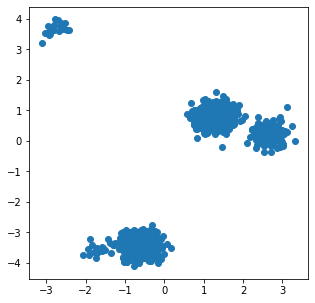

In [9]:
n = 1500
ustar_samples = tf.cast(ptarget.sample(n), dtype=tf.float32)

given.plot_samples_2d(ustar_samples)

###### Plotting histogram

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 0  4 12 13  1]


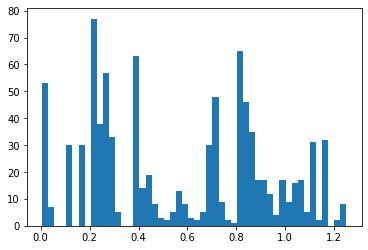

In [10]:
x = tf.cast(ptarget.sample(n_samples), dtype=tf.float32)
u = T(x, c, w, b)
pstar_x = ptarget.prob(np.asarray(x))
px_x = psource.prob(np.asarray(u))*tf.math.abs(det_J(x, c, w, b))
diff = tf.math.abs(pstar_x - px_x)
diff = tf.reshape(diff, (-1, ))
plt.hist(diff, bins=50)    
plt.show()

### **Q1 a Observations** 

#### **Theory**

According to the problem statement we can only sample from $p^*_x$. So here we make use of KL Divergence for our loss function given by the following

$Loss = D[p^*_x(x)\,||\,p_x(x;\,\theta)]$ 

which approximates to the following expected value expression (we would later take the monte carlo approximation to get the expected value)

$ \underset{\rm x\sim p^*_x}{\rm E} [\,- log(p_u(u)) - log(|J_{T^{-1}}(x;\theta)|)\,]$

Here we need to calculate $u (=T^{-1}(x))$ and $|J_{T^{-1}}(x;\theta)|$

We can get $u$ by reverse Planar Flow transformation given as follows

$u = T(x) = x + c\cdot h(w^Tx + b)$. \\

And to calculate the mod of determinant of Jacobian we use this expression taught in class

$|J_T(x; \theta)| = |1+h'(w^Tx+b)c^Tw|$ \\

Note that the $T$ used above is the reverse Planar transformation (which we are approximating to $T^{-1}$ as we cannot find $T^{-1}$ explicitly)

#### **Workflow**

We start off by sampling from our target probability distribution i.e. $p^*_x$ to get $x$ . We use the reverse Planar transformation here, to get samples from our modelled distribution denoted by $u$. We can get probability values of $u$ from $p_u$ and then take the logarithm of the same to get $log(p_u(u))$

Next, to get the Jacobian term, we start with a function to calculate the determinant of the same using Gradient Tape and a loop. Then we take the absolute value of the same and finally a logarithm to get the term $log(|J_T(x; \theta)|)$

Finally to get the expected values we simply use Monte-Carlo Approximation as follows

$Loss = \frac{1}{N}\sum_{i=1}^{N} - log(p_u(T(x_i)) - log(|J_{T}(x_i;\theta)|)$

#### **Observations**

$p_x(x) = p_u(T^{-1}(x)).|J_{T^{-1}}(x;\theta)| = p_u(T^{-1}(x)).|J_T(T^{-1}(x);\theta)|^{-1}$  \\

- From the above formulations, we can clearly see that we need the reverse transformation function to plot the samples from our modelled distribution, i.e. we need $T^{-1}$ which is not trivial to find out. Hence we cannot really plot the samples from $p_x$

- From the histogram plot we can concurr that the difference between the predicted and actual probabilities is not zero which tells us that the model is highly erroneous for this particular case. Also, the histogram is very noisy hinting that the model is inaccurate here.


### Question 1b

In [11]:
##### Q1 b. #####

epoch = 500
ptarget = given.GMM()
psource = given.Gaussian(mu=np.asarray([0, 0]), sigma=np.asarray([[1, 0], [0, 1]]))
n_samples = 30
eta = 0.001

In [12]:
# modelling planar flow function

def T(u, c, w, b):
  # return u + c*(tf.math.tanh(tf.matmul(u, w) + b))
  return u + tf.matmul(tf.math.tanh(tf.matmul(u, w) + b), tf.transpose(c))

In [13]:
# function to find determinant of jacobian

def det_J(u, c, w, b):

  detJ = []

  for i in u:
    with tf.GradientTape(persistent=True) as tape:
      m = tf.matmul(tf.transpose(w), tf.reshape(i, (2,1))) + b
      h = tf.math.tanh(m)
    dh_dm = tape.gradient(h, m)
    det = 1 + (dh_dm)*tf.matmul(tf.transpose(w), c)
    detJ.append(det)

  return detJ

In [14]:
# initializing parameters

c = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32)
w = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32)
b = tf.Variable(tf.random.uniform([1, 1], 0, 1), trainable=True, dtype=tf.float32)

In [15]:
# S = 30
# D = 2

def step2(c, w, b, ptarget, psource, eta, n_samples, loss=False):
  with tf.GradientTape(persistent=True) as tape2:
    # ptarget = given.GMM()
    # psource = given.Gaussian(mu=[0, 0], sigma=[[1, 0], [0, 1]])
    # n_samples = 30

    u = tf.cast(psource.sample(n_samples), dtype=tf.float32) # u = 30 x 2
    p_u_u = psource.prob(np.asarray(u)) # p_u_u = 30 x 1
    log_puu = tf.cast(tf.math.log(p_u_u), dtype=tf.float32) # log_puu = 30 x 1

    x = T(u, c, w, b) # x = 30 x 2
    p_x_star = ptarget.prob(np.asarray(x))   
    log_pxstar = tf.cast(tf.math.log(p_x_star), dtype=tf.float32)

    mod_det_J = tf.math.abs(det_J(u, c, w, b))
    log_det_J = tf.math.log(mod_det_J)

    # print(log_puu)
    # print(log_det_J)
    # print(log_pxstar)

    mc_loss = tf.reduce_sum(log_puu - log_det_J - log_pxstar)/n_samples
    
  dloss_dc = tape2.gradient(mc_loss, c)
  dloss_dw = tape2.gradient(mc_loss, w)
  dloss_db = tape2.gradient(mc_loss, b)
  c.assign(c - eta*dloss_dc)
  w.assign(w - eta*dloss_dw)
  b.assign(b - eta*dloss_db)

  if loss:
    return c, w, b, mc_loss.numpy()
  else:
    return c, w, b

In [16]:
for _ in tqdm.trange(epoch, desc="Training", bar_format='{l_bar}{bar:50}{r_bar}'):
  c, w, b = step2(c, w, b, ptarget, psource, eta, n_samples)

Training: 100%|██████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s]


In [17]:
print(c.numpy()) 
print(w.numpy())
print(b.numpy())

[[3.152804 ]
 [2.7277367]]
[[0.8965918]
 [0.7685758]]
[[-0.02308104]]


###### Plotting samples from modelled distribution and target distribution respectively

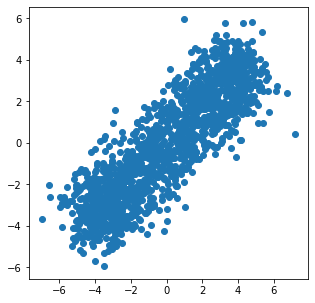

In [18]:
n = 1500

u_samples = tf.cast(psource.sample(n), dtype=tf.float32)
x_samples = T(u_samples, c, w, b)

given.plot_samples_2d(x_samples)

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[105 373 356 576  90]


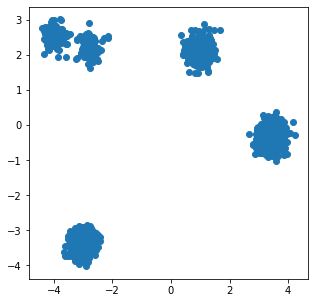

In [19]:
xstar_samples = tf.cast(ptarget.sample(n), dtype=tf.float32)

given.plot_samples_2d(xstar_samples)

###### Plotting histogram

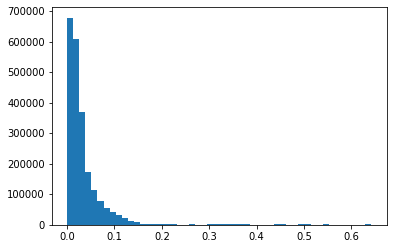

In [20]:
u_o = tf.cast(psource.sample(n), dtype=tf.float32)
x_o = tf.cast(T(u_o, c, w, b), dtype=tf.float32)
pstar_x = ptarget.prob(np.asarray(x_o))
px_x = psource.prob(np.asarray(u_o))/tf.math.abs(det_J(u_o, c, w, b))
diff = tf.math.abs(pstar_x - px_x)
diff = tf.reshape(diff, (-1, ))
plt.hist(diff, bins=50)    
plt.show()

### **Q1 b Observations**

#### **Theory**

In the problem statement we are given only the values of $p^*_x$. So here, we make use of reverse KL divergence to calculate our loss function which is given by 


$Loss = D[p_x(x;\,\theta)\,||\,p^*_x(x)]$ 


which approximates to the following expected value expression (we would later take the monte carlo approximation to get the expected value)


$\underset{\rm u\sim p_u}{\rm E} [\,log(p_u(u)) + log(|J_T(u;\theta)|^{-1}) - log(p^*_x(T(u)))\,]$


Here, we need to calculate $u$ and $|J_T(u;\theta)|$


$u$ is given by $T(x)$ which is a transformation function


For the transformation function, we make use of Planar Flow Model 

$x = T(u) = u + c\cdot h(w^Tu + b)$ 

And to calculate the mod of determinant of Jacobian we use this expression taught in class

$|J_T(u; \theta)| = |1+h'(w^Tu+b)c^Tw|$ \\

#### **Workflow**

We start off by sampling from our source probability distribution i.e. $p_u$ to get $u$. From here, we can easily get the probability vaues of the sampled $u$ form the source probability distribution and take the logarithm of the same to get the term $log(p_u(u))$

To get the Jacobian term, we start with a function to calculate the determinant of the same using Gradient Tape and a loop. Then we take the absolute value of the same and finally a logarithm to get the term $log(|J_T(u;\theta)|^{-1})$

Then we can apply the Planar Flow transformation to the $u$ obtained above to sample $x$ from our Planar Flow Model $p_x(x)$. We can get the probability values from the target distribution and further take their logarithm to get $log(p^*_x(x))$

Finally to get the expected values we simply use Monte-Carlo Approximation as follows

$Loss = \frac{1}{N}\sum_{i=1}^{N} log(p_u(u_i)) - log(|J_T(u_i;\theta)|) - log(p^*_x(T(u_i)))$


#### **Observations**
- Here, we observe that our model is able to mimic a somewhat stretched gaussian distribution. The plots from the target distribution have some "clusters" of probability masses. However, our modelled distribution's sample plot is very far away from the actual target distribution in the sense that it is unable to form the probability masses into distinct segments. The two plots are very dissimilar telling us that our model is not giving the best of even plausible results for this problem case

- For the histogram we see that the majority of cases lay in the near to zero bin, which may suggest that the difference in the probabilities of our modelled distribution and our target distribution is very very less. However, we can clearly see a fault here. In the above cases, Planar model did not seem to fit properly on our target distribution. Howcome our histogram is so... perfect? Well, here due to the transformation, the distributions might not be in the same scale and simply taking their difference is not the best way to analyse our model's performance. Theindividual values may be very low and their difference might be near zero, which may put them in the "near zero" bin; however, we can clearly see that this is a faulty thing to do


### Q1 c.

In [21]:
##### Q1 c. #####
lepoch = 500

Training:   0%|                                                  | 0/500 [00:00<?, ?it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 13  7  8  1]


Training:   0%|                                                  | 1/500 [00:00<04:06,  2.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  7 11  0]


Training:   0%|▏                                                 | 2/500 [00:01<04:51,  1.71it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  6 14  0]


Training:   1%|▎                                                 | 3/500 [00:01<05:01,  1.65it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  7 12  1]


Training:   1%|▍                                                 | 4/500 [00:02<04:43,  1.75it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5  7 10  4]


Training:   1%|▌                                                 | 5/500 [00:02<04:29,  1.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  4 10  9  3]


Training:   1%|▌                                                 | 6/500 [00:03<04:22,  1.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  7  4 10  5]


Training:   1%|▋                                                 | 7/500 [00:03<04:40,  1.76it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 11  4 14  1]


Training:   2%|▊                                                 | 8/500 [00:04<04:46,  1.72it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  9 12  1]


Training:   2%|▉                                                 | 9/500 [00:05<04:37,  1.77it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8 12  6  2]


Training:   2%|█                                                 | 10/500 [00:05<04:28,  1.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[1 8 9 9 3]


Training:   2%|█                                                 | 11/500 [00:06<04:18,  1.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  6 10  5]


Training:   2%|█▏                                                | 12/500 [00:06<04:20,  1.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 9 9 8 0]


Training:   3%|█▎                                                | 13/500 [00:07<04:18,  1.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 7 8 8 3]


Training:   3%|█▍                                                | 14/500 [00:07<04:26,  1.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8 10  9  1]


Training:   3%|█▌                                                | 15/500 [00:07<03:43,  2.17it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  7 11  3]


Training:   3%|█▌                                                | 16/500 [00:08<03:11,  2.52it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 10  7 13  0]


Training:   3%|█▋                                                | 17/500 [00:08<02:49,  2.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  7 11  3]


Training:   4%|█▊                                                | 18/500 [00:08<02:37,  3.07it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  7 13  9  0]


Training:   4%|█▉                                                | 19/500 [00:08<02:25,  3.31it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  8  5 14  3]


Training:   4%|██                                                | 20/500 [00:09<02:19,  3.45it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  6 15  2]


Training:   4%|██                                                | 21/500 [00:09<02:14,  3.57it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  5  6 16  3]


Training:   4%|██▏                                               | 22/500 [00:09<02:12,  3.62it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  5 13  2]


Training:   5%|██▎                                               | 23/500 [00:10<02:08,  3.71it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  5  6 17  1]


Training:   5%|██▍                                               | 24/500 [00:10<02:07,  3.73it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  5 12  2]


Training:   5%|██▌                                               | 25/500 [00:10<02:04,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 16  3  8  1]


Training:   5%|██▌                                               | 26/500 [00:10<02:03,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  6  5 14  2]


Training:   5%|██▋                                               | 27/500 [00:11<02:01,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 10  5 12  2]


Training:   6%|██▊                                               | 28/500 [00:11<01:58,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 5 8 9 4]


Training:   6%|██▉                                               | 29/500 [00:11<01:56,  4.05it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 10  6 12  2]


Training:   6%|███                                               | 30/500 [00:11<01:58,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  7 11  8  0]


Training:   6%|███                                               | 31/500 [00:12<01:57,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  6  7 13  1]


Training:   6%|███▏                                              | 32/500 [00:12<01:57,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  3 10 12  3]


Training:   7%|███▎                                              | 33/500 [00:12<01:58,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  6 11  6]


Training:   7%|███▍                                              | 34/500 [00:12<02:00,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5 10  3 10  2]


Training:   7%|███▌                                              | 35/500 [00:13<01:58,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  8 10  3]


Training:   7%|███▌                                              | 36/500 [00:13<01:58,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  8 11  1]


Training:   7%|███▋                                              | 37/500 [00:13<01:58,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  8 11  1]


Training:   8%|███▊                                              | 38/500 [00:13<02:01,  3.81it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 11  4 11  2]


Training:   8%|███▉                                              | 39/500 [00:14<01:59,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7 11  8  2]


Training:   8%|████                                              | 40/500 [00:14<01:57,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7 13  4  3]


Training:   8%|████                                              | 41/500 [00:14<01:55,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  7 10  1]


Training:   8%|████▏                                             | 42/500 [00:14<01:54,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5  7 11  3]


Training:   9%|████▎                                             | 43/500 [00:15<01:51,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 10  7  9  1]


Training:   9%|████▍                                             | 44/500 [00:15<01:49,  4.15it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5 12  9  2]


Training:   9%|████▌                                             | 45/500 [00:15<01:48,  4.19it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[2 8 9 9 2]


Training:   9%|████▌                                             | 46/500 [00:15<01:52,  4.05it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 11  5 10  4]


Training:   9%|████▋                                             | 47/500 [00:16<01:52,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[2 8 9 9 2]


Training:  10%|████▊                                             | 48/500 [00:16<01:51,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  4  6 16  2]


Training:  10%|████▉                                             | 49/500 [00:16<01:49,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  8 10 12  0]


Training:  10%|█████                                             | 50/500 [00:16<01:51,  4.05it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5 12  7  4  2]


Training:  10%|█████                                             | 51/500 [00:17<01:51,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  3 10 12  2]


Training:  10%|█████▏                                            | 52/500 [00:17<01:50,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  6 15  0]


Training:  11%|█████▎                                            | 53/500 [00:17<01:49,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  6  8 10  1]


Training:  11%|█████▍                                            | 54/500 [00:17<01:48,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  5 12  2]


Training:  11%|█████▌                                            | 55/500 [00:18<01:50,  4.03it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5 10  9  2]


Training:  11%|█████▌                                            | 56/500 [00:18<01:50,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5 11 12  0]


Training:  11%|█████▋                                            | 57/500 [00:18<01:50,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  6 10  2]


Training:  12%|█████▊                                            | 58/500 [00:18<01:51,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 10  5 14  0]


Training:  12%|█████▉                                            | 59/500 [00:19<01:52,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5  5 12  4]


Training:  12%|██████                                            | 60/500 [00:19<01:52,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7 11 10  0]


Training:  12%|██████                                            | 61/500 [00:19<01:52,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[6 8 8 7 1]


Training:  12%|██████▏                                           | 62/500 [00:19<01:51,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  8 11  3]


Training:  13%|██████▎                                           | 63/500 [00:20<01:51,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  8  5 14  3]


Training:  13%|██████▍                                           | 64/500 [00:20<01:49,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 10  7  9  3]


Training:  13%|██████▌                                           | 65/500 [00:20<01:45,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  5 14  3]


Training:  13%|██████▌                                           | 66/500 [00:20<01:45,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  7 14  1]


Training:  13%|██████▋                                           | 67/500 [00:21<01:45,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  7 14  1]


Training:  14%|██████▊                                           | 68/500 [00:21<01:43,  4.18it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 10  8  9  3]


Training:  14%|██████▉                                           | 69/500 [00:21<01:42,  4.19it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[3 6 8 8 5]


Training:  14%|███████                                           | 70/500 [00:21<01:43,  4.16it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  5 13  2]


Training:  14%|███████                                           | 71/500 [00:22<01:46,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 10  7 13  0]


Training:  14%|███████▏                                          | 72/500 [00:22<01:45,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  7 12  1]


Training:  15%|███████▎                                          | 73/500 [00:22<01:46,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  7 10  4]


Training:  15%|███████▍                                          | 74/500 [00:22<01:47,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5  5 15  3]


Training:  15%|███████▌                                          | 75/500 [00:23<01:48,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  7  8 11  3]


Training:  15%|███████▌                                          | 76/500 [00:23<01:48,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  3  6 15  2]


Training:  15%|███████▋                                          | 77/500 [00:23<01:47,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5 13  3  9  0]


Training:  16%|███████▊                                          | 78/500 [00:23<01:47,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  9 11  2]


Training:  16%|███████▉                                          | 79/500 [00:24<01:50,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  4  8 14  0]


Training:  16%|████████                                          | 80/500 [00:24<01:47,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[1 8 9 9 3]


Training:  16%|████████                                          | 81/500 [00:24<01:43,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  6 10  3]


Training:  16%|████████▏                                         | 82/500 [00:24<01:43,  4.03it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  8 12  1]


Training:  17%|████████▎                                         | 83/500 [00:25<01:43,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  6 12  2]


Training:  17%|████████▍                                         | 84/500 [00:25<01:41,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  6  6 14  1]


Training:  17%|████████▌                                         | 85/500 [00:25<01:42,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5  5 14  2]


Training:  17%|████████▌                                         | 86/500 [00:25<01:43,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  8 10  2]


Training:  17%|████████▋                                         | 87/500 [00:26<01:45,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 11  6 10  3]


Training:  18%|████████▊                                         | 88/500 [00:26<01:45,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[7 6 7 8 2]


Training:  18%|████████▉                                         | 89/500 [00:26<01:43,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  8  6 11  1]


Training:  18%|█████████                                         | 90/500 [00:26<01:40,  4.07it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8 11  8  1]


Training:  18%|█████████                                         | 91/500 [00:27<01:43,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  9 12  0]


Training:  18%|█████████▏                                        | 92/500 [00:27<01:42,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  9  8 13  0]


Training:  19%|█████████▎                                        | 93/500 [00:27<01:39,  4.08it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  7 13  2]


Training:  19%|█████████▍                                        | 94/500 [00:27<01:39,  4.08it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[1 9 8 9 3]


Training:  19%|█████████▌                                        | 95/500 [00:28<01:38,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  4 15  3]


Training:  19%|█████████▌                                        | 96/500 [00:28<01:40,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  6 16  1]


Training:  19%|█████████▋                                        | 97/500 [00:28<01:41,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  6 13  3]


Training:  20%|█████████▊                                        | 98/500 [00:28<01:42,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  6 12  0]


Training:  20%|█████████▉                                        | 99/500 [00:29<01:41,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  2 12  9  3]


Training:  20%|██████████                                        | 100/500 [00:29<01:41,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  7 13  2]


Training:  20%|██████████                                        | 101/500 [00:29<01:39,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  7 10  5]


Training:  20%|██████████▏                                       | 102/500 [00:29<01:37,  4.07it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  6  4 15  1]


Training:  21%|██████████▎                                       | 103/500 [00:30<01:39,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  9  3 15  0]


Training:  21%|██████████▍                                       | 104/500 [00:30<01:41,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  4  9 11  2]


Training:  21%|██████████▌                                       | 105/500 [00:30<01:40,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  8 10  2]


Training:  21%|██████████▌                                       | 106/500 [00:30<01:41,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 11  5 13  0]


Training:  21%|██████████▋                                       | 107/500 [00:31<01:40,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  5  7 15  3]


Training:  22%|██████████▊                                       | 108/500 [00:31<01:40,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  5 15  0]


Training:  22%|██████████▉                                       | 109/500 [00:31<01:39,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  9  3 15  1]


Training:  22%|███████████                                       | 110/500 [00:31<01:37,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  7 12  3]


Training:  22%|███████████                                       | 111/500 [00:32<01:38,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  8 12  0]


Training:  22%|███████████▏                                      | 112/500 [00:32<01:37,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  5 10 11  3]


Training:  23%|███████████▎                                      | 113/500 [00:32<01:39,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  4  7 12  4]


Training:  23%|███████████▍                                      | 114/500 [00:32<01:39,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  5  7 16  2]


Training:  23%|███████████▌                                      | 115/500 [00:33<01:38,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  5 13  2]


Training:  23%|███████████▌                                      | 116/500 [00:33<01:38,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  7 13  1]


Training:  23%|███████████▋                                      | 117/500 [00:33<01:35,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  7 12  2]


Training:  24%|███████████▊                                      | 118/500 [00:33<01:34,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  7 13  2]


Training:  24%|███████████▉                                      | 119/500 [00:34<01:34,  4.05it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  6 11  4]


Training:  24%|████████████                                      | 120/500 [00:34<01:34,  4.03it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  4  7 14  2]


Training:  24%|████████████                                      | 121/500 [00:34<01:34,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 6 11  5  7  1]


Training:  24%|████████████▏                                     | 122/500 [00:34<01:33,  4.03it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  8  4 10  4]


Training:  25%|████████████▎                                     | 123/500 [00:35<01:33,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  3  4 19  3]


Training:  25%|████████████▍                                     | 124/500 [00:35<01:36,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5  4 18  1]


Training:  25%|████████████▌                                     | 125/500 [00:35<01:36,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  5 13  4]


Training:  25%|████████████▌                                     | 126/500 [00:35<01:35,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  7  4 18  1]


Training:  25%|████████████▋                                     | 127/500 [00:36<01:34,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  4 14  2]


Training:  26%|████████████▊                                     | 128/500 [00:36<01:36,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[5 9 8 6 2]


Training:  26%|████████████▉                                     | 129/500 [00:36<01:35,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[2 9 9 8 2]


Training:  26%|█████████████                                     | 130/500 [00:36<01:34,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 12  4 10  1]


Training:  26%|█████████████                                     | 131/500 [00:37<01:35,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  7 11  2]


Training:  26%|█████████████▏                                    | 132/500 [00:37<01:35,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  9  6 10  2]


Training:  27%|█████████████▎                                    | 133/500 [00:37<01:35,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  9 12  1]


Training:  27%|█████████████▍                                    | 134/500 [00:37<01:35,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  6  9  3]


Training:  27%|█████████████▌                                    | 135/500 [00:38<01:34,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  4 10 12  0]


Training:  27%|█████████████▌                                    | 136/500 [00:38<01:33,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  6 11  9  0]


Training:  27%|█████████████▋                                    | 137/500 [00:38<01:31,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  7  4 14  1]


Training:  28%|█████████████▊                                    | 138/500 [00:38<01:29,  4.03it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  6 14  1]


Training:  28%|█████████████▉                                    | 139/500 [00:39<01:31,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  4 14  2]


Training:  28%|██████████████                                    | 140/500 [00:39<01:34,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  7 12  3]


Training:  28%|██████████████                                    | 141/500 [00:39<01:33,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  5 16  0]


Training:  28%|██████████████▏                                   | 142/500 [00:40<01:33,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4 10  4  7  5]


Training:  29%|██████████████▎                                   | 143/500 [00:40<01:32,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 6 9 8 3]


Training:  29%|██████████████▍                                   | 144/500 [00:40<01:32,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  2 15  3]


Training:  29%|██████████████▍                                   | 145/500 [00:40<01:32,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  6 13  3]


Training:  29%|██████████████▌                                   | 146/500 [00:41<01:30,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  3 16  2]


Training:  29%|██████████████▋                                   | 147/500 [00:41<01:28,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[5 8 6 9 2]


Training:  30%|██████████████▊                                   | 148/500 [00:41<01:27,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8 11  5  3]


Training:  30%|██████████████▉                                   | 149/500 [00:41<01:27,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  6  5 19  0]


Training:  30%|███████████████                                   | 150/500 [00:42<01:27,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[6 7 9 7 1]


Training:  30%|███████████████                                   | 151/500 [00:42<01:26,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  4  8 15  1]


Training:  30%|███████████████▏                                  | 152/500 [00:42<01:26,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  4 16  1]


Training:  31%|███████████████▎                                  | 153/500 [00:42<01:25,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  8 12  3]


Training:  31%|███████████████▍                                  | 154/500 [00:42<01:24,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  5 17  0]


Training:  31%|███████████████▌                                  | 155/500 [00:43<01:24,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  4  7 14  2]


Training:  31%|███████████████▌                                  | 156/500 [00:43<01:23,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 8 9 8 1]


Training:  31%|███████████████▋                                  | 157/500 [00:43<01:22,  4.14it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  3  8 13  1]


Training:  32%|███████████████▊                                  | 158/500 [00:43<01:22,  4.13it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  4  8 10  5]


Training:  32%|███████████████▉                                  | 159/500 [00:44<01:22,  4.12it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  7 11  3]


Training:  32%|████████████████                                  | 160/500 [00:44<01:22,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  6 11  1]


Training:  32%|████████████████                                  | 161/500 [00:44<01:22,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  7 11  2]


Training:  32%|████████████████▏                                 | 162/500 [00:44<01:21,  4.15it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  9 11  0]


Training:  33%|████████████████▎                                 | 163/500 [00:45<01:21,  4.14it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  8 14  0]


Training:  33%|████████████████▍                                 | 164/500 [00:45<01:21,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  8 12  1]


Training:  33%|████████████████▌                                 | 165/500 [00:45<01:22,  4.08it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  5 12  2]


Training:  33%|████████████████▌                                 | 166/500 [00:45<01:21,  4.08it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  5  8 15  1]


Training:  33%|████████████████▋                                 | 167/500 [00:46<01:22,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  9 11  2]


Training:  34%|████████████████▊                                 | 168/500 [00:46<01:23,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7 14  7  0]


Training:  34%|████████████████▉                                 | 169/500 [00:46<01:24,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  9 10  2]


Training:  34%|█████████████████                                 | 170/500 [00:46<01:25,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[2 9 6 8 5]


Training:  34%|█████████████████                                 | 171/500 [00:47<01:25,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  5 14  1]


Training:  34%|█████████████████▏                                | 172/500 [00:47<01:25,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[3 8 6 9 4]


Training:  35%|█████████████████▎                                | 173/500 [00:47<01:25,  3.80it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  7  8 15  0]


Training:  35%|█████████████████▍                                | 174/500 [00:48<01:25,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5  7 13  3]


Training:  35%|█████████████████▌                                | 175/500 [00:48<01:25,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  9 12  1]


Training:  35%|█████████████████▌                                | 176/500 [00:48<01:25,  3.80it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  2 11 13  2]


Training:  35%|█████████████████▋                                | 177/500 [00:48<01:22,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 12  6 10  2]


Training:  36%|█████████████████▊                                | 178/500 [00:49<01:20,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  4  8 12  4]


Training:  36%|█████████████████▉                                | 179/500 [00:49<01:22,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  2 16  2]


Training:  36%|██████████████████                                | 180/500 [00:49<01:23,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[2 9 7 9 3]


Training:  36%|██████████████████                                | 181/500 [00:49<01:22,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  7 12  1]


Training:  36%|██████████████████▏                               | 182/500 [00:50<01:21,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  7 15  0]


Training:  37%|██████████████████▎                               | 183/500 [00:50<01:19,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  4 13  3]


Training:  37%|██████████████████▍                               | 184/500 [00:50<01:17,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  7 11  8  3]


Training:  37%|██████████████████▌                               | 185/500 [00:50<01:18,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  6 10  3]


Training:  37%|██████████████████▌                               | 186/500 [00:51<01:18,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 6 11  8  5  0]


Training:  37%|██████████████████▋                               | 187/500 [00:51<01:17,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  6 14  1]


Training:  38%|██████████████████▊                               | 188/500 [00:51<01:15,  4.13it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  6 13  1]


Training:  38%|██████████████████▉                               | 189/500 [00:51<01:15,  4.12it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  4  6 15  1]


Training:  38%|███████████████████                               | 190/500 [00:51<01:14,  4.15it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[8 3 9 8 2]


Training:  38%|███████████████████                               | 191/500 [00:52<01:17,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  3 15  8  0]


Training:  38%|███████████████████▏                              | 192/500 [00:52<01:17,  3.98it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  9 11  0]


Training:  39%|███████████████████▎                              | 193/500 [00:52<01:18,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  5 17  0]


Training:  39%|███████████████████▍                              | 194/500 [00:53<01:18,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5  7 11  5]


Training:  39%|███████████████████▌                              | 195/500 [00:53<01:18,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  6 13  2]


Training:  39%|███████████████████▌                              | 196/500 [00:53<01:17,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  3 17  2]


Training:  39%|███████████████████▋                              | 197/500 [00:53<01:18,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  7 12  1]


Training:  40%|███████████████████▊                              | 198/500 [00:54<01:17,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  4 10  8  3]


Training:  40%|███████████████████▉                              | 199/500 [00:54<01:17,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  6  6 10  4]


Training:  40%|████████████████████                              | 200/500 [00:54<01:16,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8 10  9  2]


Training:  40%|████████████████████                              | 201/500 [00:54<01:17,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[2 8 8 9 3]


Training:  40%|████████████████████▏                             | 202/500 [00:55<01:16,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  7  6 15  2]


Training:  41%|████████████████████▎                             | 203/500 [00:55<01:15,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  9  8 10  0]


Training:  41%|████████████████████▍                             | 204/500 [00:55<01:14,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 8  2  6 12  2]


Training:  41%|████████████████████▌                             | 205/500 [00:55<01:15,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5  5 17  1]


Training:  41%|████████████████████▌                             | 206/500 [00:56<01:15,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5  6 13  2]


Training:  41%|████████████████████▋                             | 207/500 [00:56<01:15,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  8  5 13  4]


Training:  42%|████████████████████▊                             | 208/500 [00:56<01:14,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  9  5 10  1]


Training:  42%|████████████████████▉                             | 209/500 [00:56<01:15,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  6  5 12  2]


Training:  42%|█████████████████████                             | 210/500 [00:57<01:14,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  8  5 12  1]


Training:  42%|█████████████████████                             | 211/500 [00:57<01:12,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  6  4 14  2]


Training:  42%|█████████████████████▏                            | 212/500 [00:57<01:11,  4.05it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  8 15  0]


Training:  43%|█████████████████████▎                            | 213/500 [00:57<01:12,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  4  5 15  2]


Training:  43%|█████████████████████▍                            | 214/500 [00:58<01:11,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5 10 10  1]


Training:  43%|█████████████████████▌                            | 215/500 [00:58<01:10,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  7  6 15  1]


Training:  43%|█████████████████████▌                            | 216/500 [00:58<01:09,  4.08it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  4 12 13  1]


Training:  43%|█████████████████████▋                            | 217/500 [00:58<01:10,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  7 14  0]


Training:  44%|█████████████████████▊                            | 218/500 [00:59<01:09,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  6  9 12  0]


Training:  44%|█████████████████████▉                            | 219/500 [00:59<01:08,  4.08it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  6 12  1]


Training:  44%|██████████████████████                            | 220/500 [00:59<01:07,  4.14it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  6 13  1]


Training:  44%|██████████████████████                            | 221/500 [00:59<01:08,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  9  3 14  0]


Training:  44%|██████████████████████▏                           | 222/500 [01:00<01:07,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 14  5  7  1]


Training:  45%|██████████████████████▎                           | 223/500 [01:00<01:08,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 9 5 7 5]


Training:  45%|██████████████████████▍                           | 224/500 [01:00<01:09,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  9  6 14  1]


Training:  45%|██████████████████████▌                           | 225/500 [01:00<01:10,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[7 8 5 9 1]


Training:  45%|██████████████████████▌                           | 226/500 [01:01<01:09,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  9  4 15  0]


Training:  45%|██████████████████████▋                           | 227/500 [01:01<01:09,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8 12  7  1]


Training:  46%|██████████████████████▊                           | 228/500 [01:01<01:09,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 11  8  8  1]


Training:  46%|██████████████████████▉                           | 229/500 [01:01<01:09,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  6 11  3]


Training:  46%|███████████████████████                           | 230/500 [01:02<01:09,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 12  8  8  0]


Training:  46%|███████████████████████                           | 231/500 [01:02<01:07,  3.98it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  4  8 14  2]


Training:  46%|███████████████████████▏                          | 232/500 [01:02<01:06,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[6 6 9 8 1]


Training:  47%|███████████████████████▎                          | 233/500 [01:02<01:07,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  8 13  0]


Training:  47%|███████████████████████▍                          | 234/500 [01:03<01:06,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5  5 13  3]


Training:  47%|███████████████████████▌                          | 235/500 [01:03<01:05,  4.05it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7 11  8  1]


Training:  47%|███████████████████████▌                          | 236/500 [01:03<01:05,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  8  6 15  1]


Training:  47%|███████████████████████▋                          | 237/500 [01:03<01:06,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  9  5 11  2]


Training:  48%|███████████████████████▊                          | 238/500 [01:04<01:05,  3.98it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  6  8 15  1]


Training:  48%|███████████████████████▉                          | 239/500 [01:04<01:06,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  4 13  3]


Training:  48%|████████████████████████                          | 240/500 [01:04<01:05,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  5 11  9  0]


Training:  48%|████████████████████████                          | 241/500 [01:04<01:04,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8 14  7  0]


Training:  48%|████████████████████████▏                         | 242/500 [01:05<01:05,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6 13 10  0]


Training:  49%|████████████████████████▎                         | 243/500 [01:05<01:04,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  3 11 13  2]


Training:  49%|████████████████████████▍                         | 244/500 [01:05<01:04,  3.98it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 6  9  4 10  1]


Training:  49%|████████████████████████▌                         | 245/500 [01:05<01:06,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 11  8  9  2]


Training:  49%|████████████████████████▌                         | 246/500 [01:06<01:06,  3.81it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 6  9  5 10  0]


Training:  49%|████████████████████████▋                         | 247/500 [01:06<01:04,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4 10  3 10  3]


Training:  50%|████████████████████████▊                         | 248/500 [01:06<01:03,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  7 14  1]


Training:  50%|████████████████████████▉                         | 249/500 [01:06<01:03,  3.98it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  5  9 14  1]


Training:  50%|█████████████████████████                         | 250/500 [01:07<01:03,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  8 14  0]


Training:  50%|█████████████████████████                         | 251/500 [01:07<01:03,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6 10 11  1]


Training:  50%|█████████████████████████▏                        | 252/500 [01:07<01:03,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  6 11  3]


Training:  51%|█████████████████████████▎                        | 253/500 [01:07<01:02,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5  6 12  3]


Training:  51%|█████████████████████████▍                        | 254/500 [01:08<01:03,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  3  8 14  2]


Training:  51%|█████████████████████████▌                        | 255/500 [01:08<01:02,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  4 12  3]


Training:  51%|█████████████████████████▌                        | 256/500 [01:08<01:02,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  7  8 10  1]


Training:  51%|█████████████████████████▋                        | 257/500 [01:08<01:02,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  8 11  3]


Training:  52%|█████████████████████████▊                        | 258/500 [01:09<01:02,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 14  8  4  2]


Training:  52%|█████████████████████████▉                        | 259/500 [01:09<00:59,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  6 12  2]


Training:  52%|██████████████████████████                        | 260/500 [01:09<00:58,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 10 11  6  3]


Training:  52%|██████████████████████████                        | 261/500 [01:09<00:58,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  9  4 12  1]


Training:  52%|██████████████████████████▏                       | 262/500 [01:10<00:58,  4.05it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  6 11 12  1]


Training:  53%|██████████████████████████▎                       | 263/500 [01:10<00:57,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  7 10  9  3]


Training:  53%|██████████████████████████▍                       | 264/500 [01:10<00:56,  4.14it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  7 10  3]


Training:  53%|██████████████████████████▌                       | 265/500 [01:10<00:57,  4.12it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  6 11  3]


Training:  53%|██████████████████████████▌                       | 266/500 [01:11<00:58,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 9 4 9 4]


Training:  53%|██████████████████████████▋                       | 267/500 [01:11<00:57,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  7 12  1]


Training:  54%|██████████████████████████▊                       | 268/500 [01:11<00:57,  4.07it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  6 12  9  0]


Training:  54%|██████████████████████████▉                       | 269/500 [01:11<00:56,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  6  8 16  0]


Training:  54%|███████████████████████████                       | 270/500 [01:12<00:56,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  6 10  4]


Training:  54%|███████████████████████████                       | 271/500 [01:12<00:55,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  5 15  1]


Training:  54%|███████████████████████████▏                      | 272/500 [01:12<00:55,  4.08it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5 10  5  8  2]


Training:  55%|███████████████████████████▎                      | 273/500 [01:12<00:56,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  6  7 12  0]


Training:  55%|███████████████████████████▍                      | 274/500 [01:13<00:57,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[3 9 9 9 0]


Training:  55%|███████████████████████████▌                      | 275/500 [01:13<00:55,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5  6 10  7]


Training:  55%|███████████████████████████▌                      | 276/500 [01:13<00:54,  4.07it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  4  7 14  0]


Training:  55%|███████████████████████████▋                      | 277/500 [01:13<00:54,  4.07it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[5 7 8 9 1]


Training:  56%|███████████████████████████▊                      | 278/500 [01:14<00:54,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5  8 15  0]


Training:  56%|███████████████████████████▉                      | 279/500 [01:14<00:53,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 10  5 10  2]


Training:  56%|████████████████████████████                      | 280/500 [01:14<00:53,  4.13it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  9  5 14  2]


Training:  56%|████████████████████████████                      | 281/500 [01:14<00:52,  4.14it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  7  6 10  3]


Training:  56%|████████████████████████████▏                     | 282/500 [01:15<00:52,  4.15it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[7 6 7 7 3]


Training:  57%|████████████████████████████▎                     | 283/500 [01:15<00:52,  4.12it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 7 8 8 3]


Training:  57%|████████████████████████████▍                     | 284/500 [01:15<00:52,  4.14it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  4  9 13  3]


Training:  57%|████████████████████████████▍                     | 285/500 [01:15<00:52,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  3  8 18  0]


Training:  57%|████████████████████████████▌                     | 286/500 [01:16<00:52,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  5 13  3]


Training:  57%|████████████████████████████▋                     | 287/500 [01:16<00:53,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  7 10  3]


Training:  58%|████████████████████████████▊                     | 288/500 [01:16<00:54,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  5  4 11  5]


Training:  58%|████████████████████████████▉                     | 289/500 [01:16<00:53,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  9 11  2]


Training:  58%|████████████████████████████▉                     | 290/500 [01:17<00:53,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 13  8  7  0]


Training:  58%|█████████████████████████████                     | 291/500 [01:17<00:52,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  2 18  0]


Training:  58%|█████████████████████████████▏                    | 292/500 [01:17<00:51,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  5 13  2]


Training:  59%|█████████████████████████████▎                    | 293/500 [01:17<00:51,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  5 14  1]


Training:  59%|█████████████████████████████▍                    | 294/500 [01:18<00:52,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  7  5 13  1]


Training:  59%|█████████████████████████████▌                    | 295/500 [01:18<00:52,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  6 16  0]


Training:  59%|█████████████████████████████▌                    | 296/500 [01:18<00:52,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 7 9 9 1]


Training:  59%|█████████████████████████████▋                    | 297/500 [01:18<00:52,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 11  9  8  2]


Training:  60%|█████████████████████████████▊                    | 298/500 [01:19<00:52,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  8 10  6  2]


Training:  60%|█████████████████████████████▉                    | 299/500 [01:19<00:51,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  5  6 10  4]


Training:  60%|██████████████████████████████                    | 300/500 [01:19<00:51,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  7  7 14  2]


Training:  60%|██████████████████████████████                    | 301/500 [01:19<00:51,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  9 10  1]


Training:  60%|██████████████████████████████▏                   | 302/500 [01:20<00:51,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  8  7 10  0]


Training:  61%|██████████████████████████████▎                   | 303/500 [01:20<00:51,  3.81it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 6  7  1 15  1]


Training:  61%|██████████████████████████████▍                   | 304/500 [01:20<00:51,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 10  6 10  1]


Training:  61%|██████████████████████████████▌                   | 305/500 [01:20<00:50,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  2 10 12  5]


Training:  61%|██████████████████████████████▌                   | 306/500 [01:21<00:50,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 13  6  9  0]


Training:  61%|██████████████████████████████▋                   | 307/500 [01:21<00:50,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4 12  5  7  2]


Training:  62%|██████████████████████████████▊                   | 308/500 [01:21<00:50,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  4  8 14  1]


Training:  62%|██████████████████████████████▉                   | 309/500 [01:21<00:48,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  6  7 12  5]


Training:  62%|███████████████████████████████                   | 310/500 [01:22<00:47,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  6  5 12  2]


Training:  62%|███████████████████████████████                   | 311/500 [01:22<00:47,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  4 16  0]


Training:  62%|███████████████████████████████▏                  | 312/500 [01:22<00:46,  4.03it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  8  7 14  1]


Training:  63%|███████████████████████████████▎                  | 313/500 [01:22<00:47,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  8  4 11  3]


Training:  63%|███████████████████████████████▍                  | 314/500 [01:23<00:47,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  6 14  2]


Training:  63%|███████████████████████████████▌                  | 315/500 [01:23<00:48,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  7  8 13  1]


Training:  63%|███████████████████████████████▌                  | 316/500 [01:23<00:48,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 8 8 6 4]


Training:  63%|███████████████████████████████▋                  | 317/500 [01:24<00:47,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  7 15  0]


Training:  64%|███████████████████████████████▊                  | 318/500 [01:24<00:47,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  3 11 13  0]


Training:  64%|███████████████████████████████▉                  | 319/500 [01:24<00:47,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  4 13  3]


Training:  64%|████████████████████████████████                  | 320/500 [01:24<00:46,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5  4 16  1]


Training:  64%|████████████████████████████████                  | 321/500 [01:25<00:46,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  8 11  3]


Training:  64%|████████████████████████████████▏                 | 322/500 [01:25<00:46,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  8 11  2]


Training:  65%|████████████████████████████████▎                 | 323/500 [01:25<00:46,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  9  1 16  1]


Training:  65%|████████████████████████████████▍                 | 324/500 [01:25<00:46,  3.79it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4 11  5  7  3]


Training:  65%|████████████████████████████████▌                 | 325/500 [01:26<00:46,  3.79it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  1 11 14  1]


Training:  65%|████████████████████████████████▌                 | 326/500 [01:26<00:45,  3.80it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  8  8  2]


Training:  65%|████████████████████████████████▋                 | 327/500 [01:26<00:45,  3.81it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  4  8 15  1]


Training:  66%|████████████████████████████████▊                 | 328/500 [01:26<00:45,  3.79it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  4  6 15  4]


Training:  66%|████████████████████████████████▉                 | 329/500 [01:27<00:45,  3.79it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  6 10  9  2]


Training:  66%|█████████████████████████████████                 | 330/500 [01:27<00:46,  3.68it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  7 13  1]


Training:  66%|█████████████████████████████████                 | 331/500 [01:27<00:45,  3.73it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[2 8 9 7 4]


Training:  66%|█████████████████████████████████▏                | 332/500 [01:28<00:44,  3.75it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 10  5 13  1]


Training:  67%|█████████████████████████████████▎                | 333/500 [01:28<00:43,  3.81it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  9  7 13  1]


Training:  67%|█████████████████████████████████▍                | 334/500 [01:28<00:42,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  6 10  9  5]


Training:  67%|█████████████████████████████████▌                | 335/500 [01:28<00:41,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[3 9 9 9 0]


Training:  67%|█████████████████████████████████▌                | 336/500 [01:28<00:40,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  6 13  4]


Training:  67%|█████████████████████████████████▋                | 337/500 [01:29<00:40,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 11  5  9  2]


Training:  68%|█████████████████████████████████▊                | 338/500 [01:29<00:39,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  4  8 13  3]


Training:  68%|█████████████████████████████████▉                | 339/500 [01:29<00:39,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 12  5 11  1]


Training:  68%|██████████████████████████████████                | 340/500 [01:29<00:39,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9 10  9  1]


Training:  68%|██████████████████████████████████                | 341/500 [01:30<00:39,  4.05it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[3 8 7 8 4]


Training:  68%|██████████████████████████████████▏               | 342/500 [01:30<00:38,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  8 11  2]


Training:  69%|██████████████████████████████████▎               | 343/500 [01:30<00:39,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  5  2 20  3]


Training:  69%|██████████████████████████████████▍               | 344/500 [01:30<00:38,  4.07it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4 11  6  8  1]


Training:  69%|██████████████████████████████████▌               | 345/500 [01:31<00:37,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  7  8 10  1]


Training:  69%|██████████████████████████████████▌               | 346/500 [01:31<00:37,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 14  5  8  0]


Training:  69%|██████████████████████████████████▋               | 347/500 [01:31<00:37,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[3 9 9 8 1]


Training:  70%|██████████████████████████████████▊               | 348/500 [01:31<00:37,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  7  6 10  2]


Training:  70%|██████████████████████████████████▉               | 349/500 [01:32<00:37,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  9  7 10  2]


Training:  70%|███████████████████████████████████               | 350/500 [01:32<00:36,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  3  6 14  3]


Training:  70%|███████████████████████████████████               | 351/500 [01:32<00:36,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  6 16  1]


Training:  70%|███████████████████████████████████▏              | 352/500 [01:32<00:36,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  9  5 13  0]


Training:  71%|███████████████████████████████████▎              | 353/500 [01:33<00:36,  4.03it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5  5 14  4]


Training:  71%|███████████████████████████████████▍              | 354/500 [01:33<00:35,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 10  8 11  0]


Training:  71%|███████████████████████████████████▌              | 355/500 [01:33<00:36,  3.98it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 12  3 11  1]


Training:  71%|███████████████████████████████████▌              | 356/500 [01:33<00:36,  3.98it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  9  2 12  2]


Training:  71%|███████████████████████████████████▋              | 357/500 [01:34<00:36,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  6  8 11  2]


Training:  72%|███████████████████████████████████▊              | 358/500 [01:34<00:36,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  5  9 13  2]


Training:  72%|███████████████████████████████████▉              | 359/500 [01:34<00:36,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 10  7  9  3]


Training:  72%|████████████████████████████████████              | 360/500 [01:34<00:35,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  8  5 11  2]


Training:  72%|████████████████████████████████████              | 361/500 [01:35<00:36,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 10  4 10  3]


Training:  72%|████████████████████████████████████▏             | 362/500 [01:35<00:35,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  8 12  3]


Training:  73%|████████████████████████████████████▎             | 363/500 [01:35<00:35,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  2 13  9  2]


Training:  73%|████████████████████████████████████▍             | 364/500 [01:36<00:35,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  6  8 11  1]


Training:  73%|████████████████████████████████████▌             | 365/500 [01:36<00:34,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  4  6 13  4]


Training:  73%|████████████████████████████████████▌             | 366/500 [01:36<00:34,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  6 12  6  2]


Training:  73%|████████████████████████████████████▋             | 367/500 [01:36<00:34,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  8 11  0]


Training:  74%|████████████████████████████████████▊             | 368/500 [01:37<00:34,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 12  7  7  2]


Training:  74%|████████████████████████████████████▉             | 369/500 [01:37<00:33,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  8 13  1]


Training:  74%|█████████████████████████████████████             | 370/500 [01:37<00:32,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  6 12  1]


Training:  74%|█████████████████████████████████████             | 371/500 [01:37<00:32,  3.98it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6 11 12  0]


Training:  74%|█████████████████████████████████████▏            | 372/500 [01:38<00:32,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  5 14  2]


Training:  75%|█████████████████████████████████████▎            | 373/500 [01:38<00:32,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  4  7 11  4]


Training:  75%|█████████████████████████████████████▍            | 374/500 [01:38<00:32,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[2 5 9 9 5]


Training:  75%|█████████████████████████████████████▌            | 375/500 [01:38<00:32,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  4 15  1]


Training:  75%|█████████████████████████████████████▌            | 376/500 [01:39<00:31,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  6 10 11  3]


Training:  75%|█████████████████████████████████████▋            | 377/500 [01:39<00:31,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4 11  4  8  3]


Training:  76%|█████████████████████████████████████▊            | 378/500 [01:39<00:31,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  9 14  0]


Training:  76%|█████████████████████████████████████▉            | 379/500 [01:39<00:31,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  8 11  2]


Training:  76%|██████████████████████████████████████            | 380/500 [01:40<00:31,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  7 11  1]


Training:  76%|██████████████████████████████████████            | 381/500 [01:40<00:31,  3.81it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  3 17  2]


Training:  76%|██████████████████████████████████████▏           | 382/500 [01:40<00:30,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  9 13  0]


Training:  77%|██████████████████████████████████████▎           | 383/500 [01:40<00:30,  3.89it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 7  3  7 11  2]


Training:  77%|██████████████████████████████████████▍           | 384/500 [01:41<00:29,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  9  4 12  1]


Training:  77%|██████████████████████████████████████▌           | 385/500 [01:41<00:29,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  7 12  0]


Training:  77%|██████████████████████████████████████▌           | 386/500 [01:41<00:29,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  4  7 15  2]


Training:  77%|██████████████████████████████████████▋           | 387/500 [01:41<00:28,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  6 10  3]


Training:  78%|██████████████████████████████████████▊           | 388/500 [01:42<00:28,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  6 14  1]


Training:  78%|██████████████████████████████████████▉           | 389/500 [01:42<00:28,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  3  7 16  1]


Training:  78%|███████████████████████████████████████           | 390/500 [01:42<00:27,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  9  9  0]


Training:  78%|███████████████████████████████████████           | 391/500 [01:42<00:28,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 10  4 13  2]


Training:  78%|███████████████████████████████████████▏          | 392/500 [01:43<00:27,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  8 10  3]


Training:  79%|███████████████████████████████████████▎          | 393/500 [01:43<00:27,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  4 12  4]


Training:  79%|███████████████████████████████████████▍          | 394/500 [01:43<00:27,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  5  9 14  2]


Training:  79%|███████████████████████████████████████▌          | 395/500 [01:43<00:27,  3.76it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[3 8 8 9 2]


Training:  79%|███████████████████████████████████████▌          | 396/500 [01:44<00:27,  3.79it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  5 11 12  2]


Training:  79%|███████████████████████████████████████▋          | 397/500 [01:44<00:26,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  5 12  1]


Training:  80%|███████████████████████████████████████▊          | 398/500 [01:44<00:26,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  6 12  2]


Training:  80%|███████████████████████████████████████▉          | 399/500 [01:45<00:27,  3.73it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4 10  3 10  3]


Training:  80%|████████████████████████████████████████          | 400/500 [01:45<00:37,  2.69it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  8 12  1]


Training:  80%|████████████████████████████████████████          | 401/500 [01:45<00:33,  2.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  9 12  2]


Training:  80%|████████████████████████████████████████▏         | 402/500 [01:46<00:30,  3.22it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 10  7 12  0]


Training:  81%|████████████████████████████████████████▎         | 403/500 [01:46<00:28,  3.38it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  8  6 11  1]


Training:  81%|████████████████████████████████████████▍         | 404/500 [01:46<00:27,  3.53it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  4 11  3]


Training:  81%|████████████████████████████████████████▌         | 405/500 [01:46<00:26,  3.57it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  8 11  2]


Training:  81%|████████████████████████████████████████▌         | 406/500 [01:47<00:25,  3.64it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  7 13  1]


Training:  81%|████████████████████████████████████████▋         | 407/500 [01:47<00:24,  3.73it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  8 13  1]


Training:  82%|████████████████████████████████████████▊         | 408/500 [01:47<00:23,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  6  7 10  2]


Training:  82%|████████████████████████████████████████▉         | 409/500 [01:47<00:23,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  5 14  1]


Training:  82%|█████████████████████████████████████████         | 410/500 [01:48<00:23,  3.80it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  7 11  3]


Training:  82%|█████████████████████████████████████████         | 411/500 [01:48<00:23,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  5  8 11  2]


Training:  82%|█████████████████████████████████████████▏        | 412/500 [01:48<00:22,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  4  8 14  3]


Training:  83%|█████████████████████████████████████████▎        | 413/500 [01:49<00:23,  3.77it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  6  5 11  4]


Training:  83%|█████████████████████████████████████████▍        | 414/500 [01:49<00:22,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  7 13  1]


Training:  83%|█████████████████████████████████████████▌        | 415/500 [01:49<00:21,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  9 10  1]


Training:  83%|█████████████████████████████████████████▌        | 416/500 [01:49<00:21,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 11  7  9  1]


Training:  83%|█████████████████████████████████████████▋        | 417/500 [01:50<00:21,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  4 11 11  1]


Training:  84%|█████████████████████████████████████████▊        | 418/500 [01:50<00:20,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  6 14  2]


Training:  84%|█████████████████████████████████████████▉        | 419/500 [01:50<00:20,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  7 10 10  2]


Training:  84%|██████████████████████████████████████████        | 420/500 [01:50<00:20,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  6 11  3]


Training:  84%|██████████████████████████████████████████        | 421/500 [01:51<00:20,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  5  8 16  0]


Training:  84%|██████████████████████████████████████████▏       | 422/500 [01:51<00:20,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  8 12  1]


Training:  85%|██████████████████████████████████████████▎       | 423/500 [01:51<00:19,  3.88it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[4 6 9 6 5]


Training:  85%|██████████████████████████████████████████▍       | 424/500 [01:51<00:19,  3.91it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  8 10  3]


Training:  85%|██████████████████████████████████████████▌       | 425/500 [01:52<00:19,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 6  5  5 13  1]


Training:  85%|██████████████████████████████████████████▌       | 426/500 [01:52<00:18,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 11  9  7  0]


Training:  85%|██████████████████████████████████████████▋       | 427/500 [01:52<00:18,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  2 11 12  2]


Training:  86%|██████████████████████████████████████████▊       | 428/500 [01:52<00:17,  4.03it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  8  6 10  1]


Training:  86%|██████████████████████████████████████████▉       | 429/500 [01:53<00:17,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[3 9 7 9 2]


Training:  86%|███████████████████████████████████████████       | 430/500 [01:53<00:17,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  6 16  1]


Training:  86%|███████████████████████████████████████████       | 431/500 [01:53<00:16,  4.08it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 10  6  9  2]


Training:  86%|███████████████████████████████████████████▏      | 432/500 [01:53<00:16,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  6  4 14  3]


Training:  87%|███████████████████████████████████████████▎      | 433/500 [01:54<00:16,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  8  6 11  1]


Training:  87%|███████████████████████████████████████████▍      | 434/500 [01:54<00:16,  4.06it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 12  5  8  2]


Training:  87%|███████████████████████████████████████████▌      | 435/500 [01:54<00:15,  4.14it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  8  6 10  1]


Training:  87%|███████████████████████████████████████████▌      | 436/500 [01:54<00:15,  4.12it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  7 14  0]


Training:  87%|███████████████████████████████████████████▋      | 437/500 [01:55<00:15,  4.10it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3 10  5 11  1]


Training:  88%|███████████████████████████████████████████▊      | 438/500 [01:55<00:15,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[5 9 4 9 3]


Training:  88%|███████████████████████████████████████████▉      | 439/500 [01:55<00:14,  4.07it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  5  7 17  0]


Training:  88%|████████████████████████████████████████████      | 440/500 [01:55<00:14,  4.11it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 11  5 11  2]


Training:  88%|████████████████████████████████████████████      | 441/500 [01:55<00:14,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  8  4 14  3]


Training:  88%|████████████████████████████████████████████▏     | 442/500 [01:56<00:14,  4.02it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  4 13  3]


Training:  89%|████████████████████████████████████████████▎     | 443/500 [01:56<00:14,  4.03it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  1  7 14  4]


Training:  89%|████████████████████████████████████████████▍     | 444/500 [01:56<00:13,  4.05it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  9 11  2]


Training:  89%|████████████████████████████████████████████▌     | 445/500 [01:56<00:13,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 13  5 11  0]


Training:  89%|████████████████████████████████████████████▌     | 446/500 [01:57<00:13,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  3  8 16  1]


Training:  89%|████████████████████████████████████████████▋     | 447/500 [01:57<00:13,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  7 14  1]


Training:  90%|████████████████████████████████████████████▊     | 448/500 [01:57<00:13,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  9  6 10  3]


Training:  90%|████████████████████████████████████████████▉     | 449/500 [01:58<00:13,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 12  3 14  0]


Training:  90%|█████████████████████████████████████████████     | 450/500 [01:58<00:13,  3.78it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  6  4 14  1]


Training:  90%|█████████████████████████████████████████████     | 451/500 [01:58<00:12,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  6  5 14  1]


Training:  90%|█████████████████████████████████████████████▏    | 452/500 [01:58<00:12,  3.72it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  6 10  3]


Training:  91%|█████████████████████████████████████████████▎    | 453/500 [01:59<00:12,  3.73it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8 10  8  1]


Training:  91%|█████████████████████████████████████████████▍    | 454/500 [01:59<00:12,  3.74it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  7 13  2]


Training:  91%|█████████████████████████████████████████████▌    | 455/500 [01:59<00:11,  3.80it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8  7 12  1]


Training:  91%|█████████████████████████████████████████████▌    | 456/500 [01:59<00:11,  3.74it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6 10 11  2]


Training:  91%|█████████████████████████████████████████████▋    | 457/500 [02:00<00:11,  3.70it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  5  5 11  4]


Training:  92%|█████████████████████████████████████████████▊    | 458/500 [02:00<00:10,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  8  8  2]


Training:  92%|█████████████████████████████████████████████▉    | 459/500 [02:00<00:10,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  7  5 16  2]


Training:  92%|██████████████████████████████████████████████    | 460/500 [02:00<00:10,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8 10  9  1]


Training:  92%|██████████████████████████████████████████████    | 461/500 [02:01<00:10,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[3 8 9 9 1]


Training:  92%|██████████████████████████████████████████████▏   | 462/500 [02:01<00:09,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 12  7  8  2]


Training:  93%|██████████████████████████████████████████████▎   | 463/500 [02:01<00:09,  3.85it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 10  3 15  2]


Training:  93%|██████████████████████████████████████████████▍   | 464/500 [02:02<00:09,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  4 10 12  3]


Training:  93%|██████████████████████████████████████████████▌   | 465/500 [02:02<00:09,  3.77it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  5  8 11  4]


Training:  93%|██████████████████████████████████████████████▌   | 466/500 [02:02<00:08,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  6  4 17  2]


Training:  93%|██████████████████████████████████████████████▋   | 467/500 [02:02<00:08,  3.81it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  9 13  0]


Training:  94%|██████████████████████████████████████████████▊   | 468/500 [02:03<00:08,  3.81it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  7 11  1]


Training:  94%|██████████████████████████████████████████████▉   | 469/500 [02:03<00:08,  3.81it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  8 13  1]


Training:  94%|███████████████████████████████████████████████   | 470/500 [02:03<00:07,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  8 11  0]


Training:  94%|███████████████████████████████████████████████   | 471/500 [02:03<00:07,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  7  7 12  2]


Training:  94%|███████████████████████████████████████████████▏  | 472/500 [02:04<00:07,  3.79it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  4  6 11  5]


Training:  95%|███████████████████████████████████████████████▎  | 473/500 [02:04<00:07,  3.79it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  4  8 12  1]


Training:  95%|███████████████████████████████████████████████▍  | 474/500 [02:04<00:06,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 6  5  8 10  1]


Training:  95%|███████████████████████████████████████████████▌  | 475/500 [02:04<00:06,  3.97it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 11  8  7  2]


Training:  95%|███████████████████████████████████████████████▌  | 476/500 [02:05<00:06,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  6 11 10  0]


Training:  95%|███████████████████████████████████████████████▋  | 477/500 [02:05<00:06,  3.83it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 11  5 11  1]


Training:  96%|███████████████████████████████████████████████▊  | 478/500 [02:05<00:05,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  8  8 10  1]


Training:  96%|███████████████████████████████████████████████▉  | 479/500 [02:05<00:05,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  7  8 13  2]


Training:  96%|████████████████████████████████████████████████  | 480/500 [02:06<00:05,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4 10  6  8  2]


Training:  96%|████████████████████████████████████████████████  | 481/500 [02:06<00:04,  3.82it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 10  9 11  0]


Training:  96%|████████████████████████████████████████████████▏ | 482/500 [02:06<00:04,  3.84it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  6  6 13  1]


Training:  97%|████████████████████████████████████████████████▎ | 483/500 [02:06<00:04,  3.86it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  6  9 12  1]


Training:  97%|████████████████████████████████████████████████▍ | 484/500 [02:07<00:04,  3.90it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  5  8 12  2]


Training:  97%|████████████████████████████████████████████████▌ | 485/500 [02:07<00:03,  3.93it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0  7  3 17  3]


Training:  97%|████████████████████████████████████████████████▌ | 486/500 [02:07<00:03,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 0 10  9 11  0]


Training:  97%|████████████████████████████████████████████████▋ | 487/500 [02:07<00:03,  4.04it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  8 10  9  1]


Training:  98%|████████████████████████████████████████████████▊ | 488/500 [02:08<00:03,  4.00it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[5 7 8 8 2]


Training:  98%|████████████████████████████████████████████████▉ | 489/500 [02:08<00:02,  3.99it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2  4  8 13  3]


Training:  98%|█████████████████████████████████████████████████ | 490/500 [02:08<00:02,  4.09it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  5 11  2]


Training:  98%|█████████████████████████████████████████████████ | 491/500 [02:08<00:02,  4.07it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  4  6 17  2]


Training:  98%|█████████████████████████████████████████████████▏| 492/500 [02:09<00:02,  3.94it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 3  7  7 12  1]


Training:  99%|█████████████████████████████████████████████████▎| 493/500 [02:09<00:01,  3.87it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4 10  5 11  0]


Training:  99%|█████████████████████████████████████████████████▍| 494/500 [02:09<00:01,  3.92it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 5  6  8 11  0]


Training:  99%|█████████████████████████████████████████████████▌| 495/500 [02:09<00:01,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1 11  9  8  1]


Training:  99%|█████████████████████████████████████████████████▌| 496/500 [02:10<00:00,  4.01it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  7  6 11  2]


Training:  99%|█████████████████████████████████████████████████▋| 497/500 [02:10<00:00,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 10  7 11  0]


Training: 100%|█████████████████████████████████████████████████▊| 498/500 [02:10<00:00,  3.95it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 1  9  8 11  1]


Training: 100%|█████████████████████████████████████████████████▉| 499/500 [02:10<00:00,  3.96it/s]

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 2 11  8  8  1]


Training: 100%|██████████████████████████████████████████████████| 500/500 [02:11<00:00,  3.81it/s]


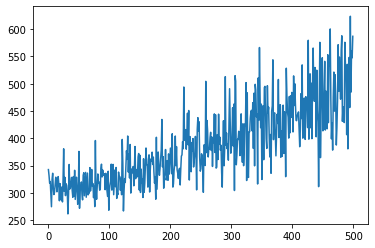

In [22]:
# plotting loss for Q1 a

c = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32) 
w = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32) 
b = tf.Variable(tf.random.uniform([1, 1], 0, 1), trainable=True, dtype=tf.float32)

loss = []

for i in tqdm.trange(lepoch, desc="Training", bar_format='{l_bar}{bar:50}{r_bar}'):
    c, w, b, l = step1(c, w, b, ptarget, psource, eta, n_samples, loss=True)
    loss.append(l)

plt.plot(loss)
plt.show()

Training: 100%|██████████████████████████████████████████████████| 500/500 [02:12<00:00,  3.78it/s]


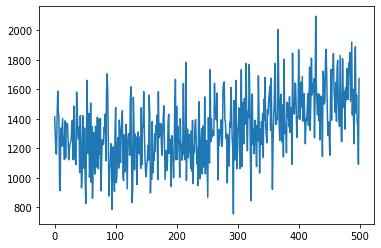

In [23]:
# plotting loss for Q1 b
c = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32) 
w = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32) 
b = tf.Variable(tf.random.uniform([1, 1], 0, 1), trainable=True, dtype=tf.float32)

loss = []

for i in tqdm.trange(lepoch, desc="Training", bar_format='{l_bar}{bar:50}{r_bar}'):
    c, w, b, l = step2(c, w, b, ptarget, psource, eta, n_samples, loss=True)
    loss.append(l)

plt.plot(loss)
plt.show()

### **Q1 c Observations**

We have plotted the loss values (for both parts of problem 1) obtained throughout the epochs to understand our model in a better manner. Here, we observe that the loss values keep oscillating about a base loss value and at the same time, this base value keeps increasing. The loss is clearly increasing instead of converging to smaller values

Our model is not able to track the losses and reduce them to better its performance. A possible reason can be the fact that there are very less parameters ($2D+1 = 5$) to train which does not work well here.

# Q2: Importance Sampling
Use the codes and models of Q1 to solve this problem
1. Assume you do not have access to `ptarget.sample()` but only to `ptarget.prob()`. Estimate $E[x^2]$ using the NF models of Q1a and Q1b. Write your obervations in the markdown block below the plots. [5 marks]
2. Evaluation: Now using the complete class `ptarget`, find $E[x^2]$ and compare it with the value computed in Q2.1. Write your obervations in the markdown block below the plots. [5 marks]

## YOUR CODE:

In [24]:
epoch = 500
n_samples = 30
eta = 0.001

In [25]:
# Training model 

c = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32) 
w = tf.Variable(tf.random.uniform([2, 1], 0, 1), trainable=True, dtype=tf.float32) 
b = tf.Variable(tf.random.uniform([1, 1], 0, 1), trainable=True, dtype=tf.float32)

for i in tqdm.trange(epoch, desc="Training", bar_format='{l_bar}{bar:50}{r_bar}'):
    c, w, b = step2(c, w, b, ptarget, psource, eta, n_samples, loss=False)

Training: 100%|██████████████████████████████████████████████████| 500/500 [02:16<00:00,  3.67it/s]


In [26]:
##### Q2.1 #####

u = tf.cast(psource.sample(n_samples), dtype=tf.float32)
x = T(np.asarray(u), c, w, b)
p_star = ptarget.prob(np.asarray(x))
psp = psource.prob(np.asarray(u))
z = det_J(u, c, w, b)
p = []
for i in range(n_samples):
  p.append(psp[i]/z[i])
fx = np.asarray(x)**2
mean = [0, 0]
for i in range(n_samples):
    mean += fx[i]*(p_star[i]/p[i])
print(mean/n_samples)

tf.Tensor([[12.452383 18.333187]], shape=(1, 2), dtype=float32)


### **Q2.1 Observations**

According to lectures, expression for expected value is as follows

$\underset{\rm x\sim p(x)}{\rm E} [\,f(x)\,] = \int_{x} f(x)p(x) dx = \int_{x} f(x)\frac{p(x)}{q(x)}q(x)dx = \underset{\rm x\sim q(x)}{\rm E} [\,f(x)\frac{p(x)}{q(x)}\,]$

We have rearranged the functions to get the latter term

Now, substitute $p(x)$ by $p^*_x(x)$ and $q(x)$ by $p_x(x)$ to get this modified expression; since sampling is from $q(x)$, in our modified expression, sampling will be from $p_x(x)$

$\int_{x} x^2p^*_x(x) dx = \int_{x} f(x)\frac{p^*_x(x)}{p_x(x)}p_x(x)dx = \underset{\rm x\sim p_x(x)}{\rm E} [\,x^2\frac{p^*_x(x)}{p_x(x)}\,]$

We use Monte-Carlo approximation to get the expected value

The mean values differ quite significantly telling us that our model is not acurate as all

In [27]:
##### Q2.2 #####
x = ptarget.sample(n_samples)
np.mean(x**2, axis=0)

[0.0791544  0.24323255 0.23282868 0.38328046 0.06150391]
[ 4  8  7 11  0]


array([9.14006013, 5.38149713])

### **Q2.2 Observations**

We observe that the Monte Carlo approximations calculated using the expression

$\underset{\rm x\sim p^*_x(x)}{\rm E} [\,x^2\,] = \frac{1}{N}\sum_{i=1}^{N} x_i^2$ (in lecture notes)

differ greatly, which is because our model is not fitting properly for this problem set

All of the plots, calculations, everything points to the observation that Planar Flow model cannot work for this given case